# **Airbnb Data Mining Notebook**

Χριστοφιλοπούλου Βασιλική - sdi2000216

In [33]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Import Libraries**

In [34]:
# Import libraries
import sys
import os
import folium
import re
import itertools
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import DataFrame, read_csv
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

# Ignoring unnecessory warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Step 1:** Read the csv files and create the train_2019.csv

We will read the data using pandas' read_csv function and then examine the dataset's information to ensure the are valid.

In [35]:
inputPath = "/content/gdrive/MyDrive/data/2019"

#files we will use to concatenate
Files = ['/listings.csv', '/listings0.csv']

#the columns that the train set must have
columnlist = ['id','host_id','host_name','zipcode','transit','bedrooms','beds',
              'review_scores_rating','number_of_reviews',
              'neighbourhood','name','latitude','longitude',
              'last_review','instant_bookable','host_since',
              'host_response_rate','host_identity_verified',
              'host_has_profile_pic','first_review','description',
              'city','cancellation_policy','bed_type','bathrooms',
              'accommodates','amenities','room_type','property_type',
              'price','availability_365','minimum_nights']

Months = ['/april', '/february', '/march'] # 2019
Months2 = ['february','march','april']

framelist = []
monthlist = []
i=0
for month in Months:
    for file in Files:
        tempfile = pd.read_csv(inputPath+month+file,index_col = False)
        tempframe = pd.DataFrame(data=tempfile)
        framelist.append(tempframe)
    for l in range(0,len(framelist)-1):
        train = framelist[0].combine_first(framelist[l+1])
    df2019 = pd.DataFrame(data = train, columns = columnlist)
    df2019.drop_duplicates(subset='id',ignore_index = True,inplace = True)  # id is primary key, no duplicates allowed in the same month
    df2019.insert(loc=len(df2019.columns),column='month_id',value = Months2[i])
    monthlist.append(df2019)
    i=i+1
df2019 = pd.concat(monthlist)
df2019.head()


id  host_id  host_name zipcode  \
0  10595    37177  Emmanouil   11526   
1  10988    37177  Emmanouil   11526   
2  10990    37177  Emmanouil   11526   
3  10993    37177  Emmanouil  115 26   
4  10995    37177  Emmanouil   11526   

                                             transit  bedrooms  beds  \
0  Note: 5-day ticket for all the public transpor...       3.0   5.0   
1  Note: 5-day ticket for all the public transpor...       2.0   2.0   
2  Note: 5-day ticket for all the public transpor...       1.0   1.0   
3  Note: 5-day ticket for all the public transpor...       0.0   1.0   
4  Note: 5-day ticket for all the public transpor...       1.0   1.0   

   review_scores_rating  number_of_reviews neighbourhood  ...  bed_type  \
0                  97.0                 19    Ambelokipi  ...  Real Bed   
1                  92.0                 31    Ambelokipi  ...  Real Bed   
2                  97.0                 29    Ambelokipi  ...  Real Bed   
3                  96.0                 45    Ambelokipi  ...  Real Bed   
4                  95.0                 17    Ambelokipi  ...  Real Bed   

   bathrooms  accommodates                                          amenities  \
0        2.0             8  {TV,"Cable TV",Internet,Wifi,"Air conditioning...   
1        1.0             5  {TV,"Cable TV",Internet,Wifi,"Air conditioning...   
2        1.0             4  {TV,"Cable TV",Internet,Wifi,"Air conditioning...   
3        1.0             2  {TV,"Cable TV",Internet,Wifi,"Air conditioning...   
4        1.0             4  {TV,"Cable TV",Internet,Wifi,"Air conditioning...   

         room_type property_type   price availability_365 minimum_nights  \
0  Entire home/apt     Apartment  $73.00              222              1   
1  Entire home/apt     Apartment  $82.00                0              1   
2  Entire home/apt     Apartment  $49.00              234              1   
3  Entire home/apt     Apartment  $38.00              226              1   
4  Entire home/apt     Apartment  $49.00              249              2   

   month_id  
0  february  
1  february  
2  february  
3  february  
4  february  

[5 rows x 33 columns]

We need to make all the data valid.

In [36]:
#1. Change the price from $ to €
exchange_rate = 0.94
df2019['price'] = df2019['price'].str.replace(',', '').str.replace('$', '')
df2019['price'] = df2019['price'].str.extract(r'(\d+\.\d+|\d+)').astype(float)            # Changing data types of column price
df2019['price'] = pd.to_numeric(df2019['price'])                                          # Remove commas and dollar signs
df2019['price'] = df2019['price'] * exchange_rate

#2. Fill in the NaN values
for x in df2019.select_dtypes('number').columns:
    df2019[x].fillna(df2019[x].mean(),inplace=True)   # With the mean of numeric collumn
df2019.fillna(method='backfill',inplace=True)         # With the previous valid of sting collumn

#3. Check for decimal values
decimal_columns = ['bedrooms', 'beds', 'bathrooms','accommodates','minimum_nights']

# Loop through each column
for column in decimal_columns:
    # Check if the column contains float values
    if df2019[column].dtype == 'float64':
        # Round up
        df2019[column] = df2019[column].apply(lambda x: int(x) if x.is_integer() else int(x) + 1)

#4. Replace greek words with their english one
df2019.replace(to_replace='ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ',                   value='Emporiko Trigono-Plaka',inplace=True)
df2019.replace(to_replace='ΠΕΝΤΑΓΩΝΟ',                                value='Pentagono',inplace=True)
df2019.replace(to_replace='ΠΑΓΚΡΑΤΙ',                                 value='Pangrati',inplace=True)
df2019.replace(to_replace='ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ',         value='Agios Konstantinos-Plateia Vathis',inplace=True)
df2019.replace(to_replace='ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ',                 value=' Mouseio-Exarcheia-Neapoli',inplace=True)

#5. Check how many data I have before I drop NaN values.
print(len(df2019))


28983


In [37]:
df2019.dropna(inplace=True)                       # If there are still mising data
print(len(df2019))
df2019.to_csv("train2019.csv")

#df.head()

28905


Given that there are only 78 rows containing invalid or missing values, the impact of data loss is negligible.

## **Step 2:** Same steps in order create the train_2023.csv

We will read the data using pandas' read_csv function and then examine the dataset's information to ensure the are valid.

In [38]:
inputPath = "/content/gdrive/MyDrive/data/2023"

#files we will use to concatenate
Files = ['/listings.csv', '/listings0.csv']

#the columns that the train set must have

#Column zipcode, transit, bed_type, bathrooms, city,cancellation_policy,
columnlist = ['id','host_id','host_name','bedrooms','beds',
              'review_scores_rating','number_of_reviews',
              'neighbourhood','name','latitude','longitude',
              'last_review','instant_bookable','host_since',
              'host_response_rate','host_identity_verified',
              'host_has_profile_pic','first_review','description',
              'accommodates','amenities','room_type','property_type',
              'price','availability_365','minimum_nights']

Months = ['/june', '/march', '/september'] # 2023
Months2 = ['march','june','september']

framelist = []
monthlist = []
i=0
for month in Months:
    for file in Files:
        tempfile = pd.read_csv(inputPath+month+file,index_col = False)
        tempframe = pd.DataFrame(data=tempfile)
        framelist.append(tempframe)
    for l in range(0,len(framelist)-1):
        train = framelist[0].combine_first(framelist[l+1])
    df2023 = pd.DataFrame(data = train, columns = columnlist)
    df2023.drop_duplicates(subset='id',ignore_index = True,inplace = True)  # id is primary key, no duplicates allowed in the same month
    df2023.insert(loc=len(df2023.columns),column='month_id',value = Months2[i])
    monthlist.append(df2023)
    i=i+1
df2023 = pd.concat(monthlist)
df2023.head()

id  host_id  host_name  bedrooms  beds  review_scores_rating  \
0   10595    37177  Emmanouil       3.0   5.0                  4.83   
1   10990    37177  Emmanouil       1.0   1.0                  4.80   
2   10993    37177  Emmanouil       NaN   2.0                  4.84   
3   10995    37177  Emmanouil       1.0   2.0                  4.80   
4  695173  3557919      Soula       2.0   3.0                  4.88   

   number_of_reviews           neighbourhood  \
0                 41  Athens, Attica, Greece   
1                 65  Athens, Attica, Greece   
2                 91  Athens, Attica, Greece   
3                 30  Athens, Attica, Greece   
4                233  Athens, Attiki, Greece   

                                                name  latitude  ...  \
0  Condo in Athens · ★4.83 · 3 bedrooms · 5 beds ...  37.98863  ...   
1  Rental unit in Athens · ★4.80 · 1 bedroom · 1 ...  37.98903  ...   
2  Rental unit in Athens · ★4.84 · Studio · 2 bed...  37.98888  ...   
3  Rental unit in Athens · ★4.80 · 1 bedroom · 2 ...  37.98903  ...   
4  Condo in Athens · ★4.88 · 2 bedrooms · 3 beds ...  37.96341  ...   

   first_review                                        description  \
0    2011-05-20  The apartment is 3-bedroom apartment with 2-ba...   
1    2012-09-06  Athens Quality Apartments - Deluxe apartment i...   
2    2012-09-24  The Studio is an <br />-excellent located <br ...   
3    2010-07-08  AQA No2 is 1-bedroom apartment (47m2), on the ...   
4    2014-04-25  My unique artistic comfortable two bedroom apa...   

  accommodates                                          amenities  \
0            8  ["Coffee maker", "Hot water", "Bed linens", "E...   
1            4  ["Coffee maker", "Hot water", "Bed linens", "E...   
2            2  ["Coffee maker", "Hot water", "Bed linens", "E...   
3            4  ["Coffee maker", "Hot water", "Bed linens", "E...   
4            5  ["Coffee maker", "Hot water", "Dedicated works...   

         room_type       property_type    price availability_365  \
0  Entire home/apt        Entire condo  $200.00              139   
1  Entire home/apt  Entire rental unit   $70.00              163   
2  Entire home/apt  Entire rental unit   $64.00               91   
3  Entire home/apt  Entire rental unit   $77.00              167   
4  Entire home/apt        Entire condo  $115.00              245   

  minimum_nights  month_id  
0              1     march  
1              1     march  
2              1     march  
3              1     march  
4              5     march  

[5 rows x 27 columns]

We need to make all the data valid.

In [39]:
#1. Change the price from $ to €
exchange_rate = 0.94
df2023['price'] = df2023['price'].astype(str)
df2023['price'] = df2023['price'].str.replace(',', '').str.replace('$', '')
df2023['price'] = df2023['price'].str.extract(r'(\d+\.\d+|\d+)').astype(float)            # Changing data types of column price
df2023['price'] = pd.to_numeric(df2023['price'])                                          # Remove commas and dollar signs
df2023['price'] = df2023['price'] * exchange_rate

#2. Fill in the NaN values
for x in df2023.select_dtypes('number').columns:
    df2023[x].fillna(df2023[x].mean(),inplace=True)   # With the mean of numeric collumn
df2023.fillna(method='backfill',inplace=True)         # With the previous valid of sting collumn

#3. Check for decimal values
decimal_columns = ['bedrooms', 'beds','accommodates','minimum_nights']

# Loop through each column
for column in decimal_columns:
    # Check if the column contains float values
    if df2023[column].dtype == 'float64':
        # Round up
        df2023[column] = df2023[column].apply(lambda x: int(x) if x.is_integer() else int(x) + 1)

#4. Replace greek words with their english one
df2023.replace(to_replace='ΠΑΓΚΡΑΤΙ',                                 value='Pangrati',inplace=True)
df2023.replace(to_replace='ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ',                   value='Emporiko Trigono-Plaka',inplace=True)
df2023.replace(to_replace='ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ',         value='Agios Konstantinos-Plateia Vathis',inplace=True)
df2023.replace(to_replace='ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ',                 value=' Mouseio-Exarcheia-Neapoli',inplace=True)
df2023.replace(to_replace='ΠΕΝΤΑΓΩΝΟ',                                value='Pentagono',inplace=True)
df2023.replace(to_replace='Athens, Attica, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athina, Greece',                           value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athens, Attiki, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athina, Attika',                           value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Αθήνα, Attikhs',                           value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Αθήνα, Αττικη, Greece',                    value='Athens, Greece',inplace=True)
df2023.replace(to_replace='ATHENS, KERAMEIKOS, Greece',               value='Keramikos',inplace=True)
df2023.replace(to_replace='ΠΡΟΜΠΟΝΑ',                                 value='Prompona',inplace=True)
df2023.replace(to_replace='Athens, ΜΕΤΑΞΟΥΡΓΕΙΟ, Greece',             value='Metaxourgio',inplace=True)
df2023.replace(to_replace='Αθήνα, Κολωνός, Greece',                   value='Kolonos',inplace=True)
df2023.replace(to_replace='ΡΙΖΟΥΠΟΛΗ',                                value='Rizoupoli',inplace=True)
df2023.replace(to_replace='Athina, Koukaki, Centre, Greece',          value='Koukaki',inplace=True)
df2023.replace(to_replace='Αθήνα, Αμπελοκηποι, Greece',               value='Ampelokipi',inplace=True)
df2023.replace(to_replace='Αθήνα, Αττικής, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Μενεμένη, Greece',                         value='Menemeni, Greece',inplace=True)
df2023.replace(to_replace='Αττική, Greece',                           value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Αθήνα, αττικης, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athens, Αττική, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Ampelokipi , Athens, Greece',              value='Ampelokipi',inplace=True)
df2023.replace(to_replace='Athens , Sepolia, Greece',                 value='Sepolia',inplace=True)
df2023.replace(to_replace='Αθήνα, Ιλισια, Greece',                    value='Ilisia',inplace=True)
df2023.replace(to_replace='ATHENS , Attica, Greece',                  value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Kolonos, Attika, Greece',                  value='Kolonos, Greece',inplace=True)
df2023.replace(to_replace='Αθήνα, ΑΤΤΙΚΗ, Greece, Greece',            value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athens, Kypseli, Greece',                  value='Kypseli',inplace=True)
df2023.replace(to_replace='Αθήνα, GR, Attiki, Greece',                value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Αθηνα, Greece',                            value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athina, AtticaAttica, Greece',             value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Αθήνα, αττικη\nΑττικη, Greece',            value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athina, attica, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Αθήνα, Attikhs, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athens, Αθήνα, Greece, Greece',            value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athens, Attica region, Greece',            value='Athens, Greece',inplace=True)
df2023.replace(to_replace='AGIOS NIKOLAOS, ATHINA, ATTICA, Greece',   value='Agios Nikolasos',inplace=True)
df2023.replace(to_replace='ΠΟΛΥΓΩΝΟ',                                 value='Polygono',inplace=True)
df2023.replace(to_replace='Athens/Kypseli, Attiki, Greece',           value='Kypseli',inplace=True)
df2023.replace(to_replace='Αθήνα, ΑΓΙΟΣ ΑΡΤΕΜΙΟΣ ΠΑΓΚΡΑΤΙ, Greece',   value='Pangrati',inplace=True)
df2023.replace(to_replace='ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ',                           value='Agios Nikolaos',inplace=True)
df2023.replace(to_replace='ΑΚΡΟΠΟΛΗ',                                 value='Akropoli',inplace=True)
df2023.replace(to_replace='Athens , Attiki, Greece',                  value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athina, San Juan, Greece',                 value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athens, Attika, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athina, Αττικης, Greece',                  value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athens, Athina, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athens, Thiseio, Greece',                  value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Αθήνα, Αττικης, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='athens, Greece',                           value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athens, attiki, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athina, Attica, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='ΛΥΚΑΒΗΤΤΟΣ',                               value='Lykavitos',inplace=True)
df2023.replace(to_replace='1Ο ΝΕΚΡΟΤΑΦΕΙΟ',                           value='1o Nekrotafeio',inplace=True)
df2023.replace(to_replace='Attiki, Kolonaki, Athens, Greece',         value='Kolonaki',inplace=True)
df2023.replace(to_replace='ΑΜΠΕΛΟΚΗΠΟΙ',                              value='Ampelokipi',inplace=True)
df2023.replace(to_replace='ΑΝΩ ΠΑΤΗΣΙΑ',                              value='Ano Patisia',inplace=True)
df2023.replace(to_replace='ΑΚΑΔΗΜΙΑ ΠΛΑΤΩΝΟΣ',                        value='Akadimia Platonos',inplace=True)
df2023.replace(to_replace='ΝΙΡΒΑΝΑ',                                  value='Nirvana',inplace=True)
df2023.replace(to_replace='ΡΗΓΙΛΛΗΣ',                                 value='Rigillis',inplace=True)
df2023.replace(to_replace='ΓΚΑΖΙ',                                    value='Gazi',inplace=True)
df2023.replace(to_replace='Athens , Sepolia, Greece',                 value='Sepolia',inplace=True)
df2023.replace(to_replace='Gazi, Athens, Greece',                     value='Gazi',inplace=True)
df2023.replace(to_replace='ΚΕΡΑΜΕΙΚΟΣ',                               value='Keramikos',inplace=True)
df2023.replace(to_replace='Athens getway, Greece',                    value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athina, GA, Greece',                       value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athina, Attiki, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='ATHENS , Attica, Greece',                  value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Αθήνα, ΑΤΤΙΚΗ, Greece',                    value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athina, Koukaki, Greece',                  value='Koukaki',inplace=True)
df2023.replace(to_replace='Athina, Athens, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athènes, Greece',                          value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Αθήνα, Αττική, Greece',                    value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Αθήνα, Greece',                            value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athens , Greece',                          value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athina, Atiki, Greece',                    value='Athens, Greece',inplace=True)
df2023.replace(to_replace=' Athens, Greece',                          value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athina, Attikis, Greece',                  value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Athina, Atiiki, Greece',                   value='Athens, Greece',inplace=True)
df2023.replace(to_replace='Αθήνα, Athens, Greece',                    value='Athens, Greece',inplace=True)
df2023.replace(to_replace='ATHENS, Greece',                           value='Athens, Greece',inplace=True)
df2023.replace(to_replace='ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ',                          value='Plateia Attikis',inplace=True)
df2023.replace(to_replace='ΚΟΛΩΝΟΣ',                                  value='Kolonos',inplace=True)
df2023.replace(to_replace='ΓΚΥΖΗ',                                    value='Gkizi',inplace=True)
df2023.replace(to_replace='ΝΕΑ ΚΥΨΕΛΗ',                               value='Nea Kypseli',inplace=True)
df2023.replace(to_replace='ΕΛΛΗΝΟΡΩΣΩΝ',                              value='Kypseli',inplace=True)
df2023.replace(to_replace='ΙΛΙΣΙΑ',                                   value='Ilisia',inplace=True)
df2023.replace(to_replace='Αθήνα, Ανω Πετράλωνα, Greece',             value='Ano Petralona',inplace=True)
df2023.replace(to_replace=' Αθήνα, Λυκαβήττος, Greece',               value='Lykavitos',inplace=True)
df2023.replace(to_replace='Monastiraki .Αθήνα, Αττικη, Greece',       value='Monastiraki',inplace=True)
df2023.replace(to_replace='ΣΤΑΘΜΟΣ ΛΑΡΙΣΗΣ',                          value='Stathmos Larisis',inplace=True)
df2023.replace(to_replace='Συκιές, Greece',                           value='Sikies, Greece',inplace=True)
df2023.replace(to_replace='Kolonaki, Attica, Greece',                 value='Kolonaki',inplace=True)
df2023.replace(to_replace='ΣΕΠΟΛΙΑ',                                  value='Sepolia',inplace=True)
df2023.replace(to_replace='ΠΕΤΡΑΛΩΝΑ',                                value='Petralona',inplace=True)
df2023.replace(to_replace='ΓΟΥΒΑ',                                    value='Gouva',inplace=True)
df2023.replace(to_replace='Plaka, Athens, Greece',                    value='Plaka',inplace=True)
df2023.replace(to_replace='ΚΟΛΟΚΥΝΘΟΥ',                               value='Kolokinthou',inplace=True)
df2023.replace(to_replace=' Mouseio-Exarcheia-Neapoli',               value='Mouseio-Exarcheia-Neapoli',inplace=True)
df2023.replace(to_replace='ΠΕΔΙΟ ΑΡΕΩΣ',                              value='Pedion Areos',inplace=True)
df2023.replace(to_replace='ΣΤΑΔΙΟ',                                   value='Stadio',inplace=True)
df2023.replace(to_replace='ΝΕΟΣ ΚΟΣΜΟΣ',                              value='Neos Kosmos',inplace=True)
df2023.replace(to_replace='ΘΗΣΕΙΟ',                                   value='Thiseio',inplace=True)
df2023.replace(to_replace='ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ',                      value='Koukaki - Makrigianni',inplace=True)
df2023.replace(to_replace='Athens, Ambelokipi, Greece',               value='Ampelokipi',inplace=True)
df2023.replace(to_replace='ΚΥΨΕΛΗ',                                   value='Kypseli',inplace=True)
df2023.replace(to_replace='ΓΟΥΔΙ',                                    value='Goudi',inplace=True)
df2023.replace(to_replace='ΑΝΩ ΚΥΨΕΛΗ',                               value='Ano Kypseli',inplace=True)
df2023.replace(to_replace='ΠΑΤΗΣΙΑ',                                  value='Patisia',inplace=True)
df2023.replace(to_replace='ΒΟΤΑΝΙΚΟΣ',                                value='Vatanikos',inplace=True)
df2023.replace(to_replace='ΚΟΛΩΝΑΚΙ',                                 value='Kolonaki',inplace=True)
df2023.replace(to_replace='ΑΓΙΟΣ ΕΛΕΥΘΕΡΙΟΣ',                         value='Agios Eletherios',inplace=True)
df2023.replace(to_replace='ΖΑΠΠΕΙΟ',                                  value='Zappeio',inplace=True)
df2023.replace(to_replace='ΠΛΑΤΕΙΑ ΑΜΕΡΙΚΗΣ',                         value='Plateia Amerikis',inplace=True)


#5. Check how many data I have before I drop NaN values.
print(len(df2023))


37035


In [40]:
df2023.dropna(inplace=True)                       # If there are still mising data
print(len(df2023))
df2023.to_csv("train2023.csv")

37018


Given that there are only 17 rows containing invalid or missing values, the impact of data loss is negligible.

## **1.1 The most common room type**

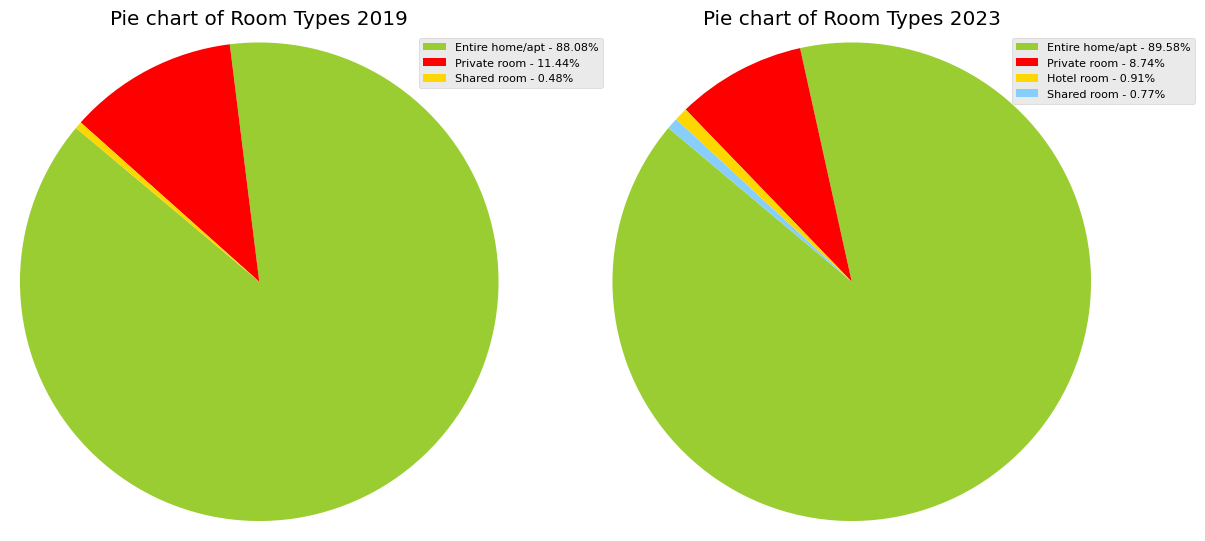

In [41]:
years = [2019, 2023]

fig, axs = plt.subplots(1, len(years), figsize=(12, 6))

for i, year in enumerate(years):
    room_counts = globals()[f'df{year}']['room_type'].value_counts()

    # Extracting room types and their counts
    room_types = room_counts.index
    counts = room_counts.values
    percentage = 100. * counts / counts.sum()

    # Plotting the pie chart
    colors = ['yellowgreen', 'red', 'gold', 'lightskyblue']
    patches, texts = axs[i].pie(counts, colors=colors, startangle=140, radius=1.2)
    labels = ['{0} - {1:1.2f}%'.format(i, j) for i, j in zip(room_types, percentage)]

    # Sorting legend based on count
    sort_legend = True
    if sort_legend:
        patches, labels, dummy = zip(*sorted(zip(patches, labels, counts),
                                             key=lambda x: x[2],
                                             reverse=True))

    axs[i].legend(patches, labels, loc='upper right', bbox_to_anchor=(1.2, 1.), fontsize=8)
    axs[i].set_title(f'Pie chart of Room Types {year}')

plt.tight_layout()
plt.show()

## **1.2  Fluctuation of price**
We need to calulate the mean price for each month, in order to display the variation of prices.

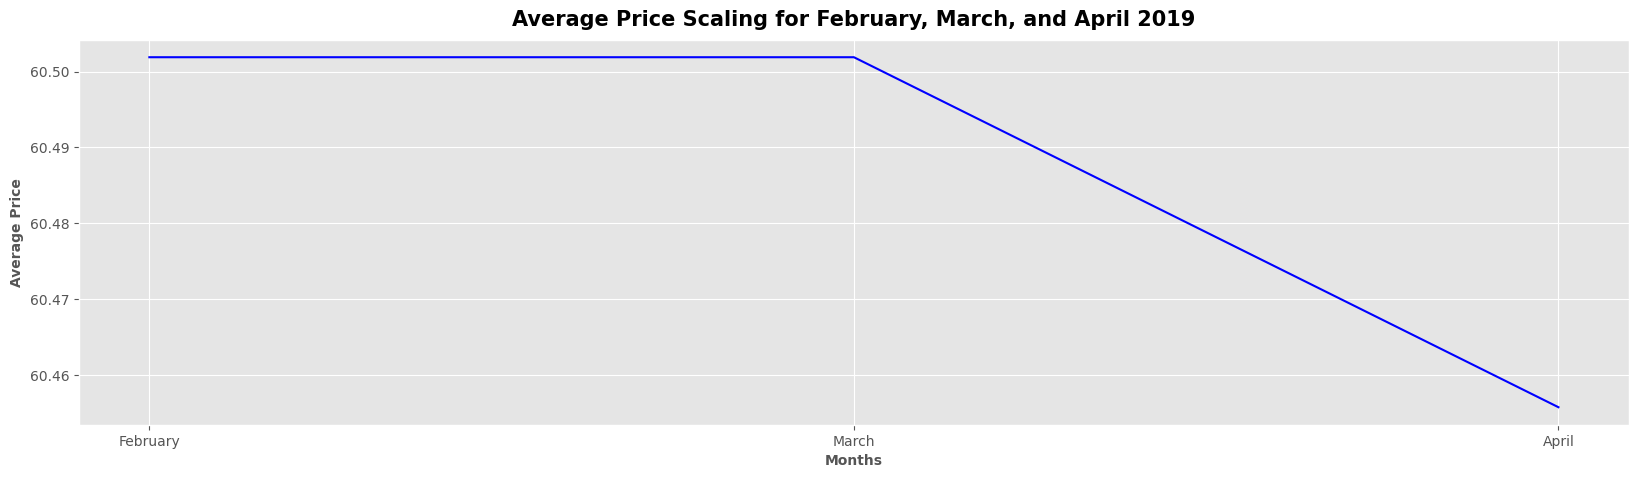

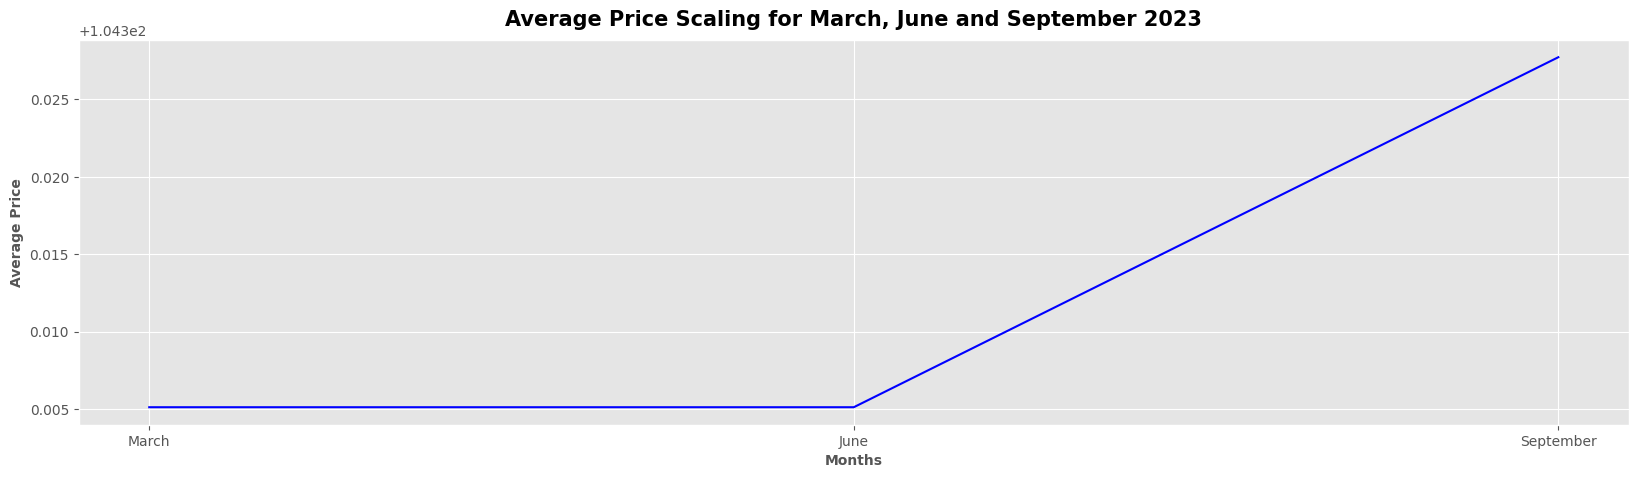

In [42]:
mean1 = df2019.groupby(by='month_id', sort=False)['price'].mean()
mean2 = df2023.groupby(by='month_id', sort=False)['price'].mean()

months1 = ['February', 'March', 'April']
months2 = ['March','June','September']

plt.style.use('ggplot')

# Plot the data 2019
plt.figure(figsize=(20, 5))
plt.plot(months1, mean1, color='blue')
plt.title('Average Price Scaling for February, March, and April 2019', fontweight='bold', fontsize=15, pad=10)
plt.xlabel('Months', fontweight='bold', fontsize=10)
plt.ylabel('Average Price', fontweight='bold', fontsize=10)
plt.grid(True)
plt.show()

# Plot the data 2023
plt.figure(figsize=(20, 5))
plt.plot(months2, mean2, color='blue')
plt.title('Average Price Scaling for March, June and September 2023', fontweight='bold', fontsize=15, pad=10)
plt.xlabel('Months', fontweight='bold', fontsize=10)
plt.ylabel('Average Price', fontweight='bold', fontsize=10)
plt.grid(True)
plt.show()


## **1.3 Five most reviewed neighbourhoods**

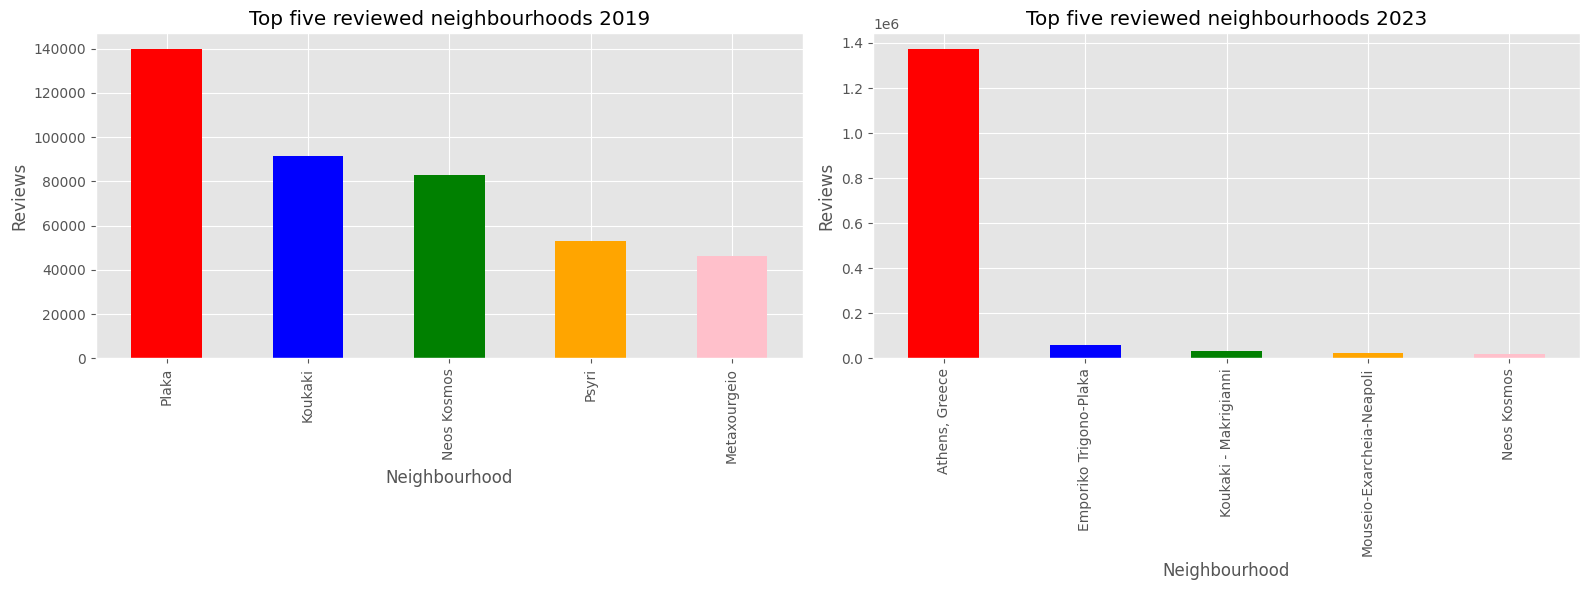

In [43]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
neighbourhoods19 = df2019.groupby(by='neighbourhood', sort=False)
neighbourhoods23 = df2023.groupby(by='neighbourhood', sort=False)

# Plot the data 2019
reviews_2019 = neighbourhoods19['number_of_reviews'].sum().sort_values(ascending=False).head(5)
reviews_2019.plot(kind='bar', color=['red', 'blue', 'green', 'orange', 'pink'], ax=axs[0])
axs[0].set_xlabel('Neighbourhood')
axs[0].set_ylabel('Reviews')
axs[0].set_title('Top five reviewed neighbourhoods 2019')

# Plot the data 2023
reviews_2023 = neighbourhoods23['number_of_reviews'].sum().sort_values(ascending=False).head(5)
reviews_2023.plot(kind='bar', color=['red', 'blue', 'green', 'orange', 'pink'], ax=axs[1])
axs[1].set_xlabel('Neighbourhood')
axs[1].set_ylabel('Reviews')
axs[1].set_title('Top five reviewed neighbourhoods 2023')

plt.tight_layout()
plt.show()

## **1.4 The neighborhood with the most properties**

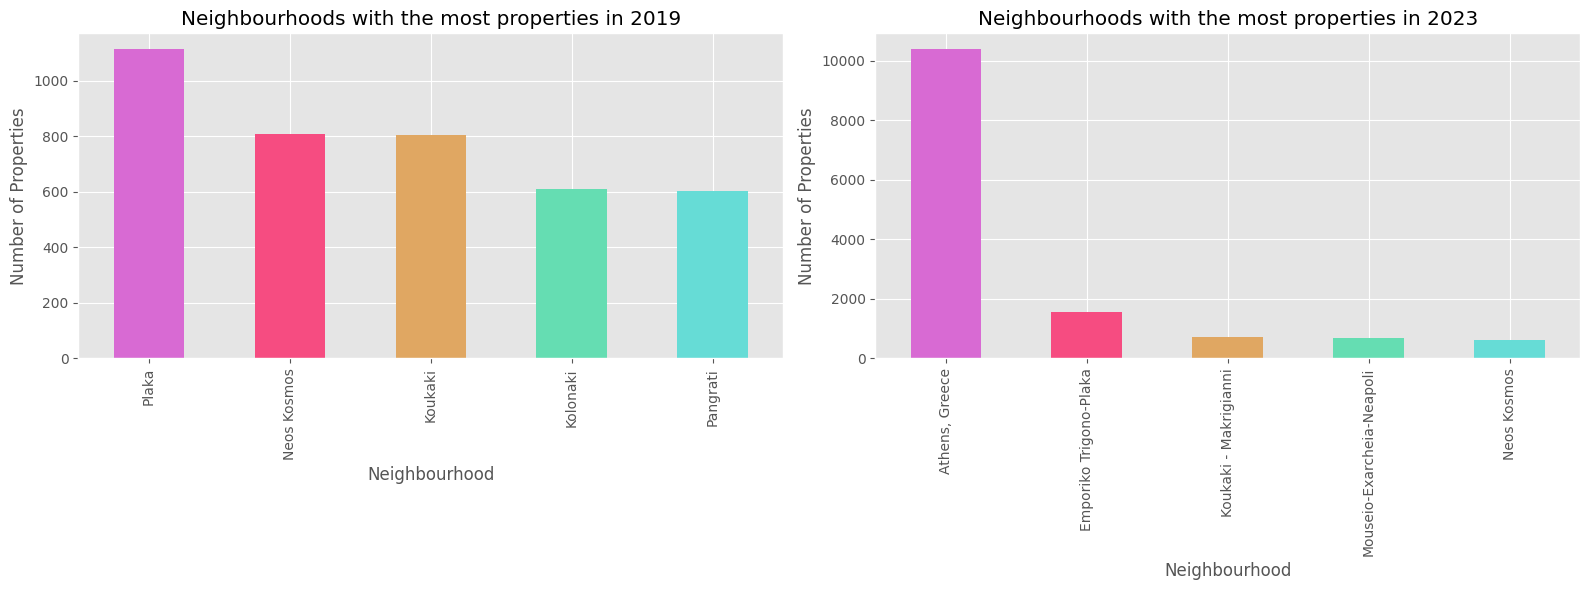

In [44]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the data 2019
properties19 = df2019.groupby('neighbourhood')['id'].nunique().sort_values(ascending=False).head(5)
properties19.plot(kind='bar', color=['#D86AD3', '#F64C81', '#E0A762', '#65DDB2', '#66DCD6'], ax=axs[0])

axs[0].set_xlabel('Neighbourhood')
axs[0].set_ylabel('Number of Properties')
axs[0].set_title('Neighbourhoods with the most properties in 2019')

# Plot the data 2023
properties23 = df2023.groupby('neighbourhood')['id'].nunique().sort_values(ascending=False).head(5)
properties23.plot(kind='bar', color=['#D86AD3', '#F64C81', '#E0A762', '#65DDB2', '#66DCD6'], ax=axs[1])
axs[1].set_xlabel('Neighbourhood')
axs[1].set_ylabel('Number of Properties')
axs[1].set_title('Neighbourhoods with the most properties in 2023')

plt.tight_layout()
plt.show()

## **1.5 Number of properties per neighborhood per month**

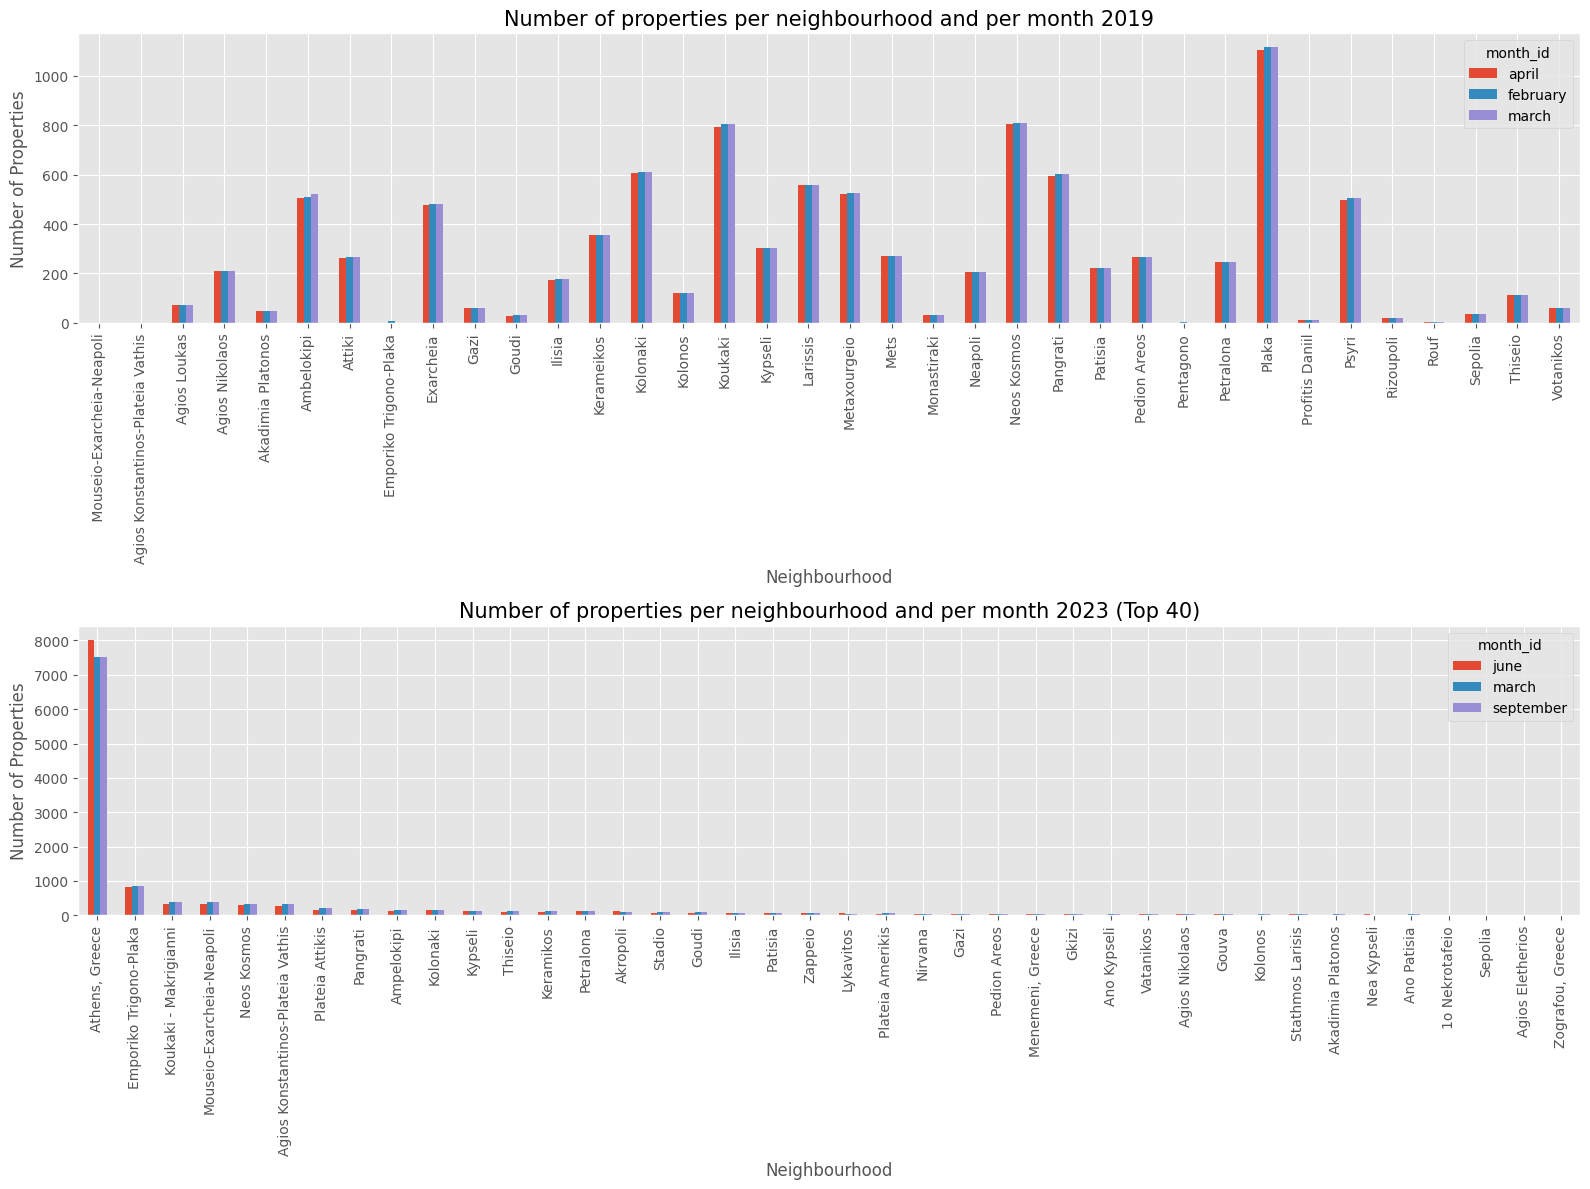

In [45]:
plt.style.use('ggplot')

result19 = df2019.groupby(['neighbourhood', 'month_id']).size().unstack(fill_value=0)
result23 = df2023.groupby(['neighbourhood', 'month_id']).size().unstack(fill_value=0)

# 2023 has too many neighbors so I kept 40 of them
top_40_2023 = result23.sum(axis=1).sort_values(ascending=False).head(40)
result23 = result23.loc[top_40_2023.index]

fig, axs = plt.subplots(2, 1, figsize=(16, 12))

# Plot the data 2019
result19.plot(kind='bar', ax=axs[0])
axs[0].set_title('Number of properties per neighbourhood and per month 2019', fontsize=15)
axs[0].set_xlabel('Neighbourhood', fontsize=12)
axs[0].set_ylabel('Number of Properties', fontsize=12)
axs[0].tick_params(axis='x', rotation=90)
axs[0].grid(True)

# Plot the data 2023 (showing only the top 40 neighborhoods)
result23.plot(kind='bar', ax=axs[1])
axs[1].set_title('Number of properties per neighbourhood and per month 2023 (Top 40)', fontsize=15)
axs[1].set_xlabel('Neighbourhood', fontsize=12)
axs[1].set_ylabel('Number of Properties', fontsize=12)
axs[1].tick_params(axis='x', rotation=90)
axs[1].grid(True)

plt.tight_layout()
plt.show()

## **1.6 A histogram of neighborhoods**

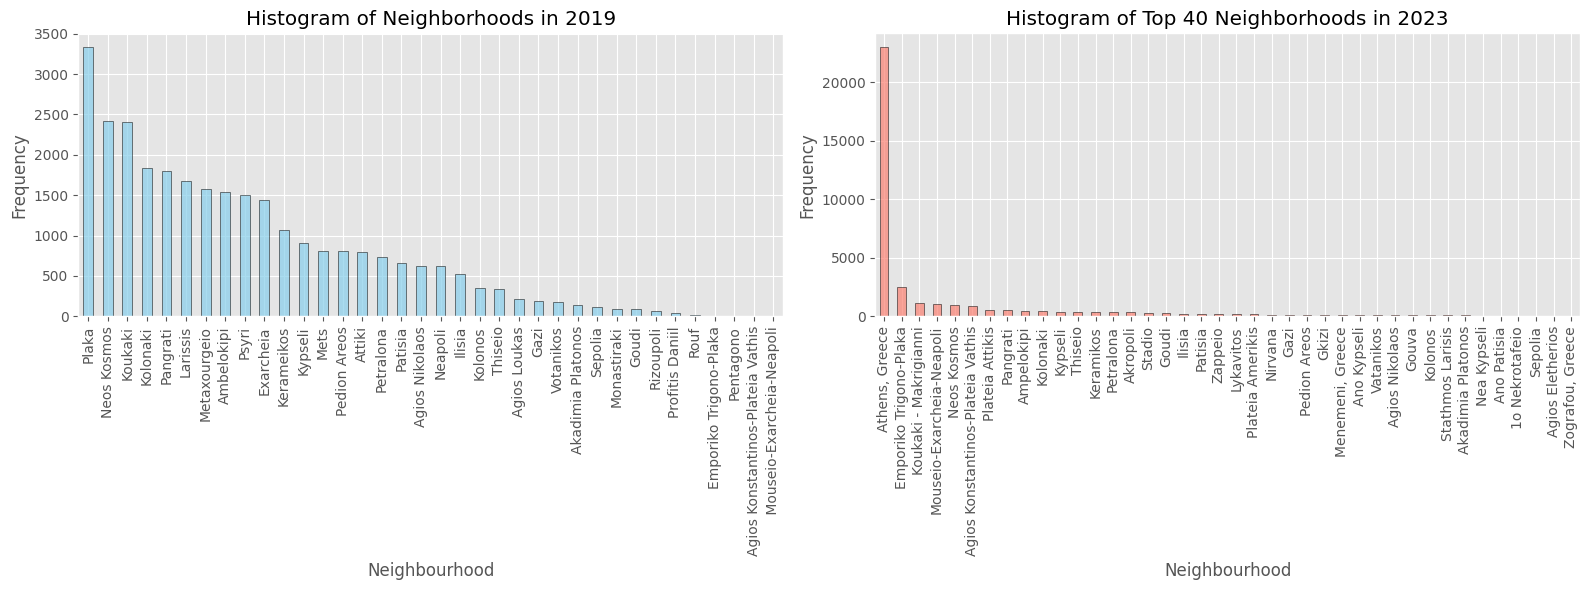

In [46]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the data for 2019
result19 = df2019['neighbourhood'].value_counts()
result19.plot(kind='bar', ax=axs[0], color='skyblue', edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Neighbourhood')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Neighborhoods in 2019')

# Plot the data for 2023 (showing only the top 40 neighborhoods)
result23_top40 = df2023['neighbourhood'].value_counts().head(40)
result23_top40.plot(kind='bar', ax=axs[1], color='salmon', edgecolor='black', alpha=0.7)
axs[1].set_xlabel('Neighbourhood')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Top 40 Neighborhoods in 2023')

plt.tight_layout()

## **1.7 Most common room type in each neighborhood**

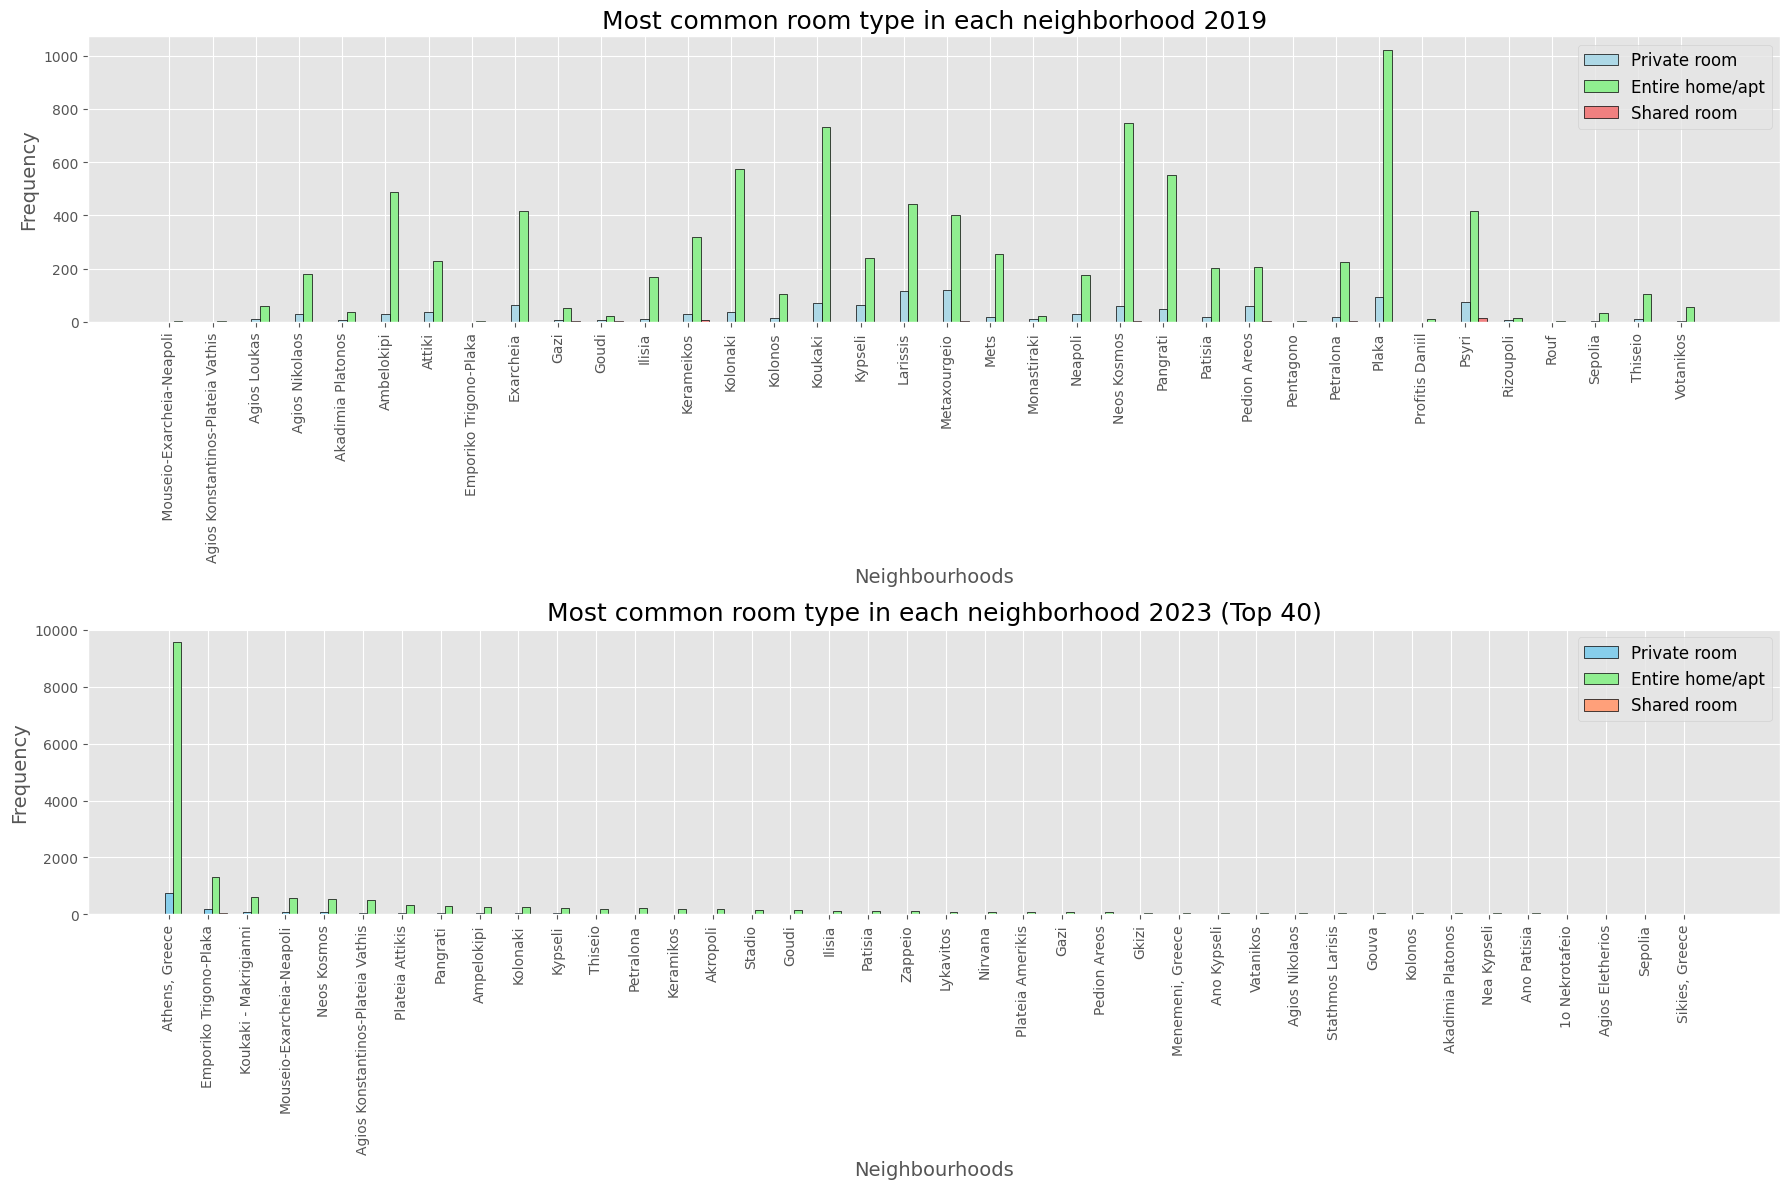

In [47]:
plt.style.use('ggplot')

# Group data by neighbourhood and room_type and count the unique IDs for both years
tempDf19 = df2019[['room_type', 'neighbourhood', 'id']].groupby(['neighbourhood', 'room_type']).agg({'id':'nunique'}).unstack(fill_value=0)
tempDf23 = df2023[['room_type', 'neighbourhood', 'id']].groupby(['neighbourhood', 'room_type']).agg({'id':'nunique'}).unstack(fill_value=0)

# 2023 has too many neighbors so I kept 40 of them
top_neighbourhoods_2023 = tempDf23.sum(axis=1).sort_values(ascending=False).head(40)
tempDf23 = tempDf23.loc[top_neighbourhoods_2023.index]

# Get the neighbourhoods
neighbourhoods19 = tempDf19.index
neighbourhoods23 = tempDf23.index

# Extracting counts for each room type for both years
privateRoom19 = tempDf19['id']['Private room']
entireHomeApt19 = tempDf19['id']['Entire home/apt']
sharedRoom19 = tempDf19['id']['Shared room']

privateRoom23 = tempDf23['id']['Private room']
entireHomeApt23 = tempDf23['id']['Entire home/apt']
sharedRoom23 = tempDf23['id']['Shared room']

barWidth = 0.2

# Set position of bars on X axis
r1 = np.arange(len(neighbourhoods19))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

r4 = np.arange(len(neighbourhoods23))
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))

# Plot the data for 2019
ax1.bar(r1, privateRoom19, color='lightblue', width=barWidth, edgecolor='black', label='Private room')
ax1.bar(r2, entireHomeApt19, color='lightgreen', width=barWidth, edgecolor='black', label='Entire home/apt')
ax1.bar(r3, sharedRoom19, color='lightcoral', width=barWidth, edgecolor='black', label='Shared room')
ax1.set_xticks(range(len(neighbourhoods19)))
ax1.set_xticklabels(neighbourhoods19, rotation='vertical', fontsize=10)
ax1.set_title('Most common room type in each neighborhood 2019', fontsize=18)
ax1.set_xlabel('Neighbourhoods', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True)

# Plot the data for 2023 (showing only the top 40 neighborhoods)
ax2.bar(r4, privateRoom23, color='skyblue', width=barWidth, edgecolor='black', label='Private room')
ax2.bar(r5, entireHomeApt23, color='lightgreen', width=barWidth, edgecolor='black', label='Entire home/apt')
ax2.bar(r6, sharedRoom23, color='lightsalmon', width=barWidth, edgecolor='black', label='Shared room')
ax2.set_xticks(range(len(neighbourhoods23)))
ax2.set_xticklabels(neighbourhoods23, rotation='vertical', fontsize=10)
ax2.set_title('Most common room type in each neighborhood 2023 (Top 40)', fontsize=18)
ax2.set_xlabel('Neighbourhoods', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True)

plt.tight_layout()
plt.show()


## **1.8 Most expensive room type**


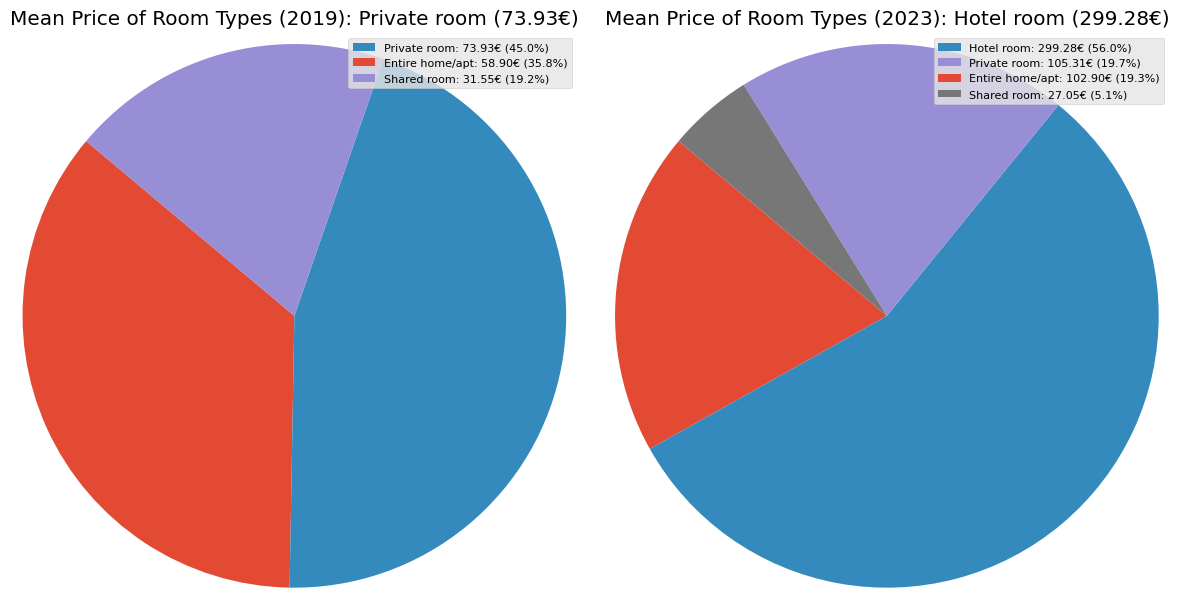

In [48]:
years = [2019, 2023]

fig, axs = plt.subplots(1, len(years), figsize=(12, 6))

for i, year in enumerate(years):
    room_prices = globals()[f'df{year}'].groupby('room_type')['price'].mean()

    # Extracting room types and their mean prices
    room_types = room_prices.index
    mean_prices = room_prices.values

    counts = mean_prices
    percentage = 100. * counts / counts.sum()

    # Find the most expensive room type
    most_expensive_index = mean_prices.argmax()
    most_expensive_room = room_types[most_expensive_index]
    most_expensive_price = mean_prices[most_expensive_index]

    patches, texts = axs[i].pie(mean_prices, startangle=140, radius=1.2)

    # Formatting labels
    labels = [f'{room_type}: {mean_price:.2f}€ ({percent:.1f}%)' for room_type, mean_price, percent in zip(room_types, mean_prices, percentage)]

    # Sorting legend based on count
    sort_legend = True
    if sort_legend:
        labels, patches, dummy = zip(*sorted(zip(labels, patches, counts),
                                             key=lambda x: x[2],
                                             reverse=True))

    axs[i].legend(patches, labels, loc='upper right', fontsize=8)
    axs[i].set_title(f'Mean Price of Room Types ({year}): {most_expensive_room} ({most_expensive_price:.2f}€)')

plt.tight_layout()
plt.show()


## **1.9 Folium Map of March 2019**

In [49]:
data = df2019[['latitude','longitude','id','price','bed_type','room_type','month_id']]
data = data.loc[data['month_id'] == 'march']

latitude = data['latitude'].tolist()
longitude = data['longitude'].tolist()
price = data['price'].tolist()
btype = data['bed_type'].tolist()
rtype = data['room_type'].tolist()

tooltip = 'Click me!'
for row in data.itertuples():
    map = folium.Map(location=[row.latitude, row.longitude], zoom_start=12)

for row in data[:100].itertuples():
    folium.Marker(location=[row.latitude, row.longitude], icon=folium.Icon(color='red', icon='info-sign'),tooltip=tooltip,popup=('Price:'+str(row.price)+'€' +'\n\n'+'Bed Type: '+str(row.bed_type)+'\n\n'+'Room Type: '+str(row.room_type))).add_to(map)
map

## **1.10.1 Wordclouds of neighbourhoods**

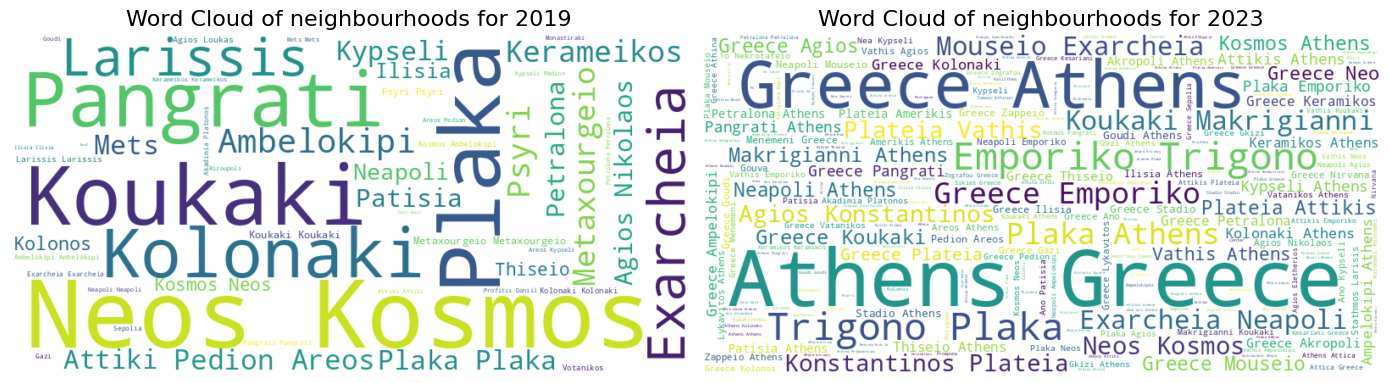

In [50]:
# Create WordCloud for 2019
wordcloud_2019 = WordCloud(
    max_words=1000,
    width=800,
    height=400,
    background_color="white"
).generate(' '.join(df2019['neighbourhood'].tolist()))

# Create WordCloud for 2023
wordcloud_2023 = WordCloud(
    max_words=1000,
    width=800,
    height=400,
    background_color="white"
).generate(' '.join(df2023['neighbourhood'].tolist()))

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot WordCloud for 2019
axs[0].imshow(wordcloud_2019, interpolation='bilinear')
axs[0].set_title('Word Cloud of neighbourhoods for 2019', fontsize=16)
axs[0].axis('off')

# Plot WordCloud for 2023
axs[1].imshow(wordcloud_2023, interpolation='bilinear')
axs[1].set_title('Word Cloud of neighbourhoods for 2023', fontsize=16)
axs[1].axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


## **1.10.2 Wordclouds of transit**

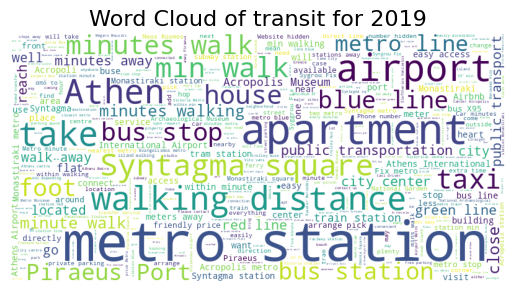

In [51]:
# Create WordCloud for 2019
wordcloud_2019 = WordCloud(
    max_words=1000,
    width=800,
    height=400,
    background_color="white"
).generate(' '.join(df2019['transit'].tolist()))
plt.imshow(wordcloud_2019)
plt.title('Word Cloud of transit for 2019', fontsize=16)
plt.axis('off')
plt.show()

# For 2023 column transit was NaN so we have removed it at step 2.


## **1.10.3 Wordclouds of description**

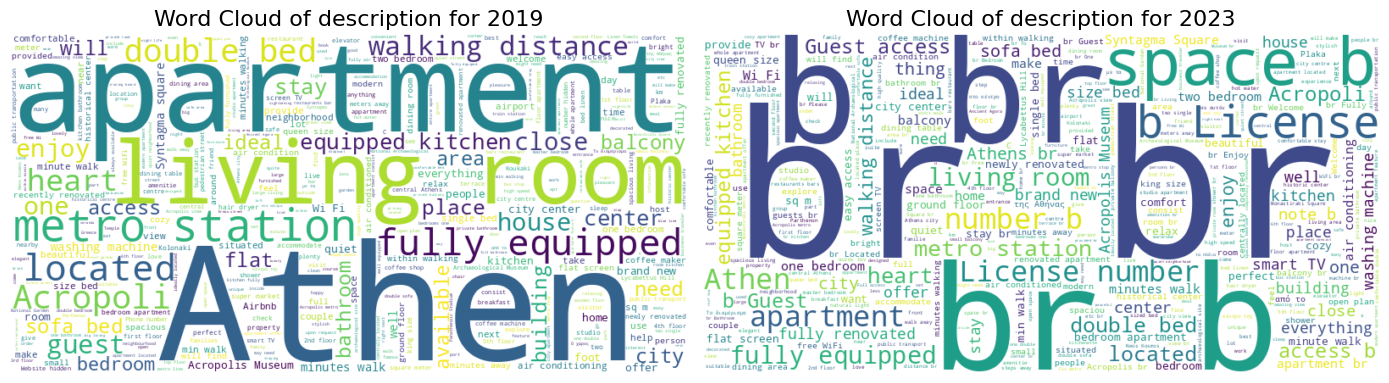

In [52]:
# Create WordCloud for 2019
wordcloud_2019 = WordCloud(
    max_words=1000,
    width=800,
    height=400,
    background_color="white"
).generate(' '.join(df2019['description'].tolist()))

# Create WordCloud for 2023
wordcloud_2023 = WordCloud(
    max_words=1000,
    width=800,
    height=400,
    background_color="white"
).generate(' '.join(df2023['description'].tolist()))

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot WordCloud for 2019
axs[0].imshow(wordcloud_2019, interpolation='bilinear')
axs[0].set_title('Word Cloud of description for 2019', fontsize=16)
axs[0].axis('off')

# Plot WordCloud for 2023
axs[1].imshow(wordcloud_2023, interpolation='bilinear')
axs[1].set_title('Word Cloud of description for 2023', fontsize=16)
axs[1].axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## **1.10.4 Wordclouds of last reviews**

The train set has a column last review where we keep the date of the last review. So we need to create a csv last_review2019 by concatenate the files reviews.csv, reviews0.csv. Then, we have to keep only the reviews which were made last.

After, we do this, we will be able to create a Wordclouds of last of review by looking the comment column in the new file.

We repeat the process fot 2023 as well.


In [53]:
# ------------------------------ 2019 -------------------------------
inputPath = "/content/gdrive/MyDrive/data/2019"

#files we will use to concatenate
Files = ['/reviews.csv', '/reviews0.csv']

#the columns that the train set must have
columnlist = ['id','date','comments']

Months = ['/april', '/february', '/march'] # 2019
Months2 = ['february','march','april']

grouped = df2019.groupby(['last_review'])

framelist = []
monthlist = []
i=0
for month in Months:
    for file in Files:
        tempfile = pd.read_csv(inputPath+month+file,index_col = False)
        tempframe = pd.DataFrame(data=tempfile)
        framelist.append(tempframe)
    for l in range(0,len(framelist)-1):
        train = framelist[0].combine_first(framelist[l+1])
    df_reviews2019 = pd.DataFrame(data = train, columns = columnlist)
    df_reviews2019.drop_duplicates(subset='id',ignore_index = True,inplace = True)  # id is primary key, no duplicates allowed in the same month
    df_reviews2019.insert(loc=len(df_reviews2019.columns),column='month_id',value = Months2[i])
    monthlist.append(df_reviews2019)
    i=i+1
df_reviews2019 = pd.concat(monthlist)

# Filter rows where the date matches one of the last_review dates
df_reviews2019 = df_reviews2019[df_reviews2019['date'].isin(df2019['last_review'])]
df_reviews2019['comments'] = df_reviews2019['comments'].fillna('').astype(str)

df_reviews2019.to_csv("last_reviews2019.csv", index=False)



In [54]:
# ------------------------------- 2023 -------------------------------
inputPath = "/content/gdrive/MyDrive/data/2023"

#files we will use to concatenate
Files = ['/reviews.csv', '/reviews0.csv']

#the columns that the train set must have
columnlist = ['id','date','comments']

Months = ['/june', '/march', '/september'] # 2023
Months2 = ['march','june','september']

grouped = df2019.groupby(['last_review'])

framelist = []
monthlist = []
i=0
for month in Months:
    for file in Files:
        tempfile = pd.read_csv(inputPath+month+file,index_col = False)
        tempframe = pd.DataFrame(data=tempfile)
        framelist.append(tempframe)
    for l in range(0,len(framelist)-1):
        train = framelist[0].combine_first(framelist[l+1])
    df_reviews2023 = pd.DataFrame(data = train, columns = columnlist)
    df_reviews2023.drop_duplicates(subset='id',ignore_index = True,inplace = True)  # id is primary key, no duplicates allowed in the same month
    df_reviews2023.insert(loc=len(df_reviews2023.columns),column='month_id',value = Months2[i])
    monthlist.append(df_reviews2023)
    i=i+1
df_reviews2023 = pd.concat(monthlist)

# Filter rows where the date matches one of the last_review dates
df_reviews2023 = df_reviews2023[df_reviews2023['date'].isin(df2023['last_review'])]
df_reviews2023['comments'] = df_reviews2023['comments'].fillna('').astype(str)

df_reviews2023.to_csv("last_reviews2023.csv", index=False)


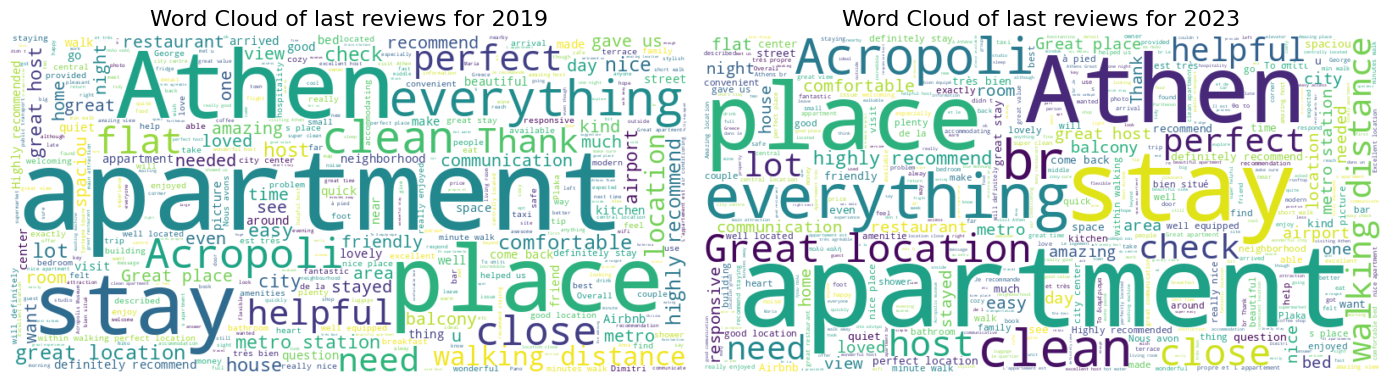

In [55]:
# Create WordCloud for 2019
grouped19 = df_reviews2019[df_reviews2019['month_id'] == 'february']
grouped23 = df_reviews2023[df_reviews2023['month_id'] == 'june']


wordcloud_2019 = WordCloud(
    max_words=1000,
    width=800,
    height=400,
    background_color="white"
).generate(' '.join(grouped19['comments'].tolist()))

# Create WordCloud for 2023
wordcloud_2023 = WordCloud(
    max_words=1000,
    width=800,
    height=400,
    background_color="white"
).generate(' '.join(grouped23['comments'].tolist()))

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot WordCloud for 2019
axs[0].imshow(wordcloud_2019, interpolation='bilinear')
axs[0].set_title('Word Cloud of last reviews for 2019', fontsize=16)
axs[0].axis('off')

# Plot WordCloud for 2023
axs[1].imshow(wordcloud_2023, interpolation='bilinear')
axs[1].set_title('Word Cloud of last reviews for 2023', fontsize=16)
axs[1].axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## **1.11 Column amenities**

In [56]:
# ------------------------------ 2019 -------------------------------
print(df2019['amenities'].unique())

['{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,Elevator,"Buzzer/wireless intercom",Heating,"Family/kid friendly",Washer,Dryer,"First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Hot water","Bed linens","Extra pillows and blankets","Ethernet connection",Microwave,"Coffee maker",Refrigerator,Dishwasher,"Dishes and silverware","Cooking basics",Oven,Stove,"Patio or balcony","Luggage dropoff allowed","Host greets you"}'
 '{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,Elevator,"Buzzer/wireless intercom",Heating,"Family/kid friendly",Washer,"First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","High chair","Pack ’n Play/travel crib","Hot water","Bed linens","Extra pillows and blankets","Ethernet connection",Microwave,"Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics",Oven,Stove,

In [57]:
category_mapping = {
    'kitchen': ['Kitchen', 'Cooking basics', 'BBQ', 'grill', 'oven','Stove', 'Coffee maker','Microwave', 'Refrigerator', 'Dishwasher', 'Dishes and silverware', 'Oven',],
    'accessibility': ['Elevator', 'Buzzer/wireless intercom', '24-hour check-in', 'Luggage dropoff allowed', 'Private entrance'],
    'Electricity_and_Technology': ['TV', 'Cable TV', 'Internet', 'Wifi', 'Ethernet connection','Sound system with Bluetooth and aux'],
    'facilities': ['Air conditioning', 'Heating', 'Washer', 'Dryer', 'Iron', 'Hair dryer', 'Hot water', 'Bed linens', 'Extra pillows and blankets', 'Patio or balcony'],
    'kids_friendly': ['Family/kid friendly', 'High chair', 'Pack ’n Play/travel crib','Board games','Books and reading material'],
    'work_friendly': ['Laptop friendly workspace'],
    'security': ['Safety card', 'Fire extinguisher', 'Smoke detector', 'Lock on bedroom door'],
    'services': ['First aid kit', 'Essentials', 'Shampoo','Hangers', 'Building staff', 'Host greets you', 'Self check-in']
}

# Define a function to categorize amenities
def categorize_amenities(amenities_str, category_mapping):
    selected_categories = []
    for category, amenities_list in category_mapping.items():
        for amenity in amenities_list:
            if amenity in amenities_str:
                selected_categories.append(category)
                break
    return ", ".join(selected_categories)

# Apply categorization to the DataFrame and replace the existing 'amenities' column
df2019['amenities'] = df2019['amenities'].apply(lambda x: categorize_amenities(x, category_mapping))

# Display the DataFrame
print(df2019['amenities'])

0       kitchen, accessibility, Electricity_and_Techno...
1       kitchen, accessibility, Electricity_and_Techno...
2       kitchen, accessibility, Electricity_and_Techno...
3       kitchen, accessibility, Electricity_and_Techno...
4       kitchen, accessibility, Electricity_and_Techno...
                              ...                        
9578    kitchen, accessibility, Electricity_and_Techno...
9579    kitchen, accessibility, Electricity_and_Techno...
9580    kitchen, accessibility, Electricity_and_Techno...
9581    kitchen, accessibility, Electricity_and_Techno...
9582    kitchen, accessibility, Electricity_and_Techno...
Name: amenities, Length: 28905, dtype: object


In [58]:
# ------------------------------ 2023 -------------------------------
print(df2023['amenities'].unique())

['["Coffee maker", "Hot water", "Bed linens", "Ethernet connection", "High chair", "Pack \\u2019n play/Travel crib", "Hangers", "Central heating", "Extra pillows and blankets", "Self check-in", "Private patio or balcony", "Refrigerator", "Essentials", "Wifi", "Cooking basics", "Oven", "Dishwasher", "Shower gel", "Free street parking", "Single level home", "Shampoo", "43\\" HDTV", "Dishes and silverware", "Hair dryer", "Laundromat nearby", "Free washer \\u2013 In unit", "Crib", "Iron", "AC - split type ductless system", "Kitchen", "Microwave", "Electric stove", "Keypad"]'
 '["Coffee maker", "Hot water", "Bed linens", "Ethernet connection", "High chair", "Pack \\u2019n play/Travel crib", "Hangers", "Central heating", "Extra pillows and blankets", "Self check-in", "Private patio or balcony", "Refrigerator", "Essentials", "Cooking basics", "Oven", "Shower gel", "Free street parking", "Single level home", "Smart lock", "Shampoo", "43\\" HDTV", "Paid parking off premises", "Dishes and silver

In [59]:
category_mapping = {
    'kitchen': ['Kitchen', 'Cooking basics', 'BBQ', 'grill', 'oven','Stove', 'Coffee maker','Microwave', 'Refrigerator', 'Dishwasher', 'Dishes and silverware', 'Oven',],
    'accessibility': ['Elevator', 'Buzzer/wireless intercom', '24-hour check-in', 'Luggage dropoff allowed', 'Private entrance'],
    'Electricity_and_Technology': ['TV', 'Cable TV', 'Internet', 'Wifi', 'Ethernet connection','Sound system with Bluetooth and aux'],
    'facilities': ['Air conditioning', 'Heating', 'Washer', 'Dryer', 'Iron', 'Hair dryer', 'Hot water', 'Bed linens', 'Extra pillows and blankets', 'Patio or balcony'],
    'kids_friendly': ['Family/kid friendly', 'High chair', 'Pack ’n Play/travel crib','Board games','Books and reading material'],
    'work_friendly': ['Laptop friendly workspace'],
    'security': ['Safety card', 'Fire extinguisher', 'Smoke detector', 'Lock on bedroom door'],
    'services': ['First aid kit', 'Essentials', 'Shampoo','Hangers', 'Building staff', 'Host greets you', 'Self check-in']
}

# Define a function to categorize amenities
def categorize_amenities(amenities_str, category_mapping):
    selected_categories = []
    for category, amenities_list in category_mapping.items():
        for amenity in amenities_list:
            if amenity in amenities_str:
                selected_categories.append(category)
                break
    return ", ".join(selected_categories)

# Apply categorization to the DataFrame and replace the existing 'amenities' column
df2023['amenities'] = df2023['amenities'].apply(lambda x: categorize_amenities(x, category_mapping))

# Display the DataFrame
print(df2023['amenities'])

0        kitchen, Electricity_and_Technology, facilitie...
1        kitchen, Electricity_and_Technology, facilitie...
2        kitchen, Electricity_and_Technology, facilitie...
3        kitchen, Electricity_and_Technology, facilitie...
4        kitchen, accessibility, Electricity_and_Techno...
                               ...                        
12323    kitchen, accessibility, Electricity_and_Techno...
12324    kitchen, accessibility, Electricity_and_Techno...
12325    kitchen, accessibility, Electricity_and_Techno...
12326    kitchen, Electricity_and_Technology, facilitie...
12327    kitchen, Electricity_and_Technology, facilitie...
Name: amenities, Length: 37018, dtype: object


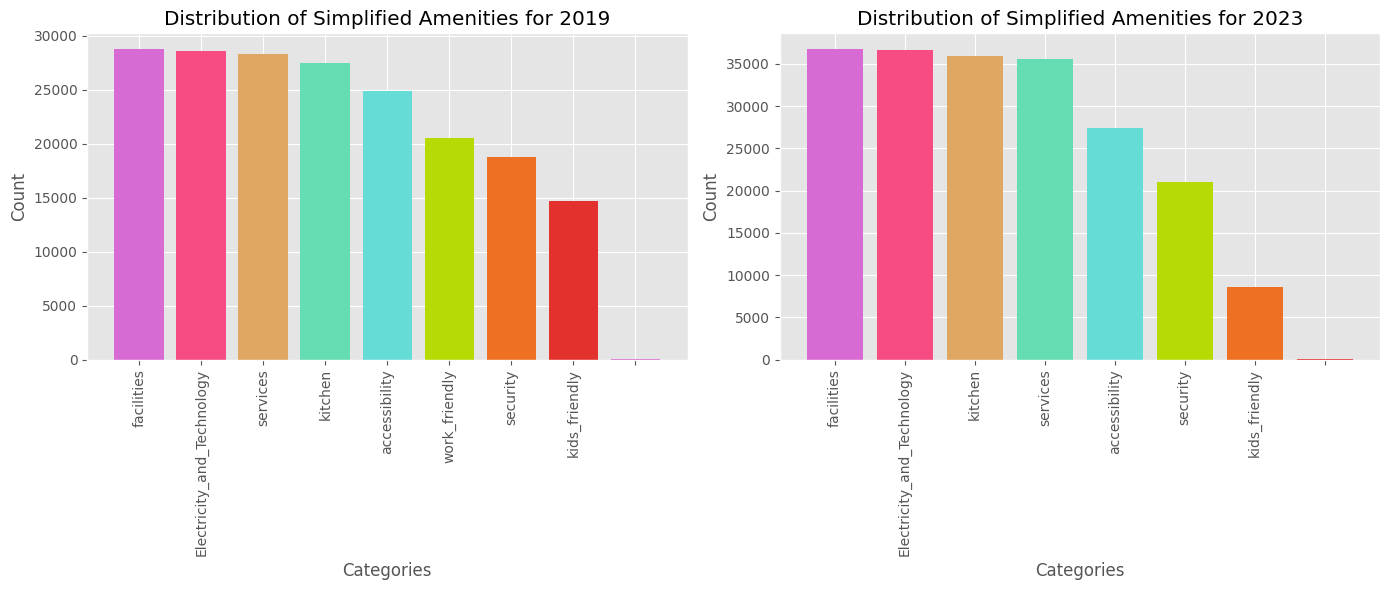

In [60]:
plt.style.use('ggplot')

# Count occurrences of each category for 2019 and 2023
category_counts19 = df2019['amenities'].str.split(', ').explode().value_counts()
category_counts23 = df2023['amenities'].str.split(', ').explode().value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for 2019
axes[0].bar(category_counts19.index, category_counts19.values, color=['#D86AD3', '#F64C81', '#E0A762', '#65DDB2', '#66DCD6','#B6DA04','#ED7023','#E3312D'])
axes[0].set_title('Distribution of Simplified Amenities for 2019')
axes[0].set_xlabel('Categories')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

# Plot for 2023
axes[1].bar(category_counts23.index, category_counts23.values, color=['#D86AD3', '#F64C81', '#E0A762', '#65DDB2', '#66DCD6','#B6DA04','#ED7023','#E3312D'])
axes[1].set_title('Distribution of Simplified Amenities for 2023')
axes[1].set_xlabel('Categories')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

## **1.12 Mean price per neighborhood (for 2 people)**

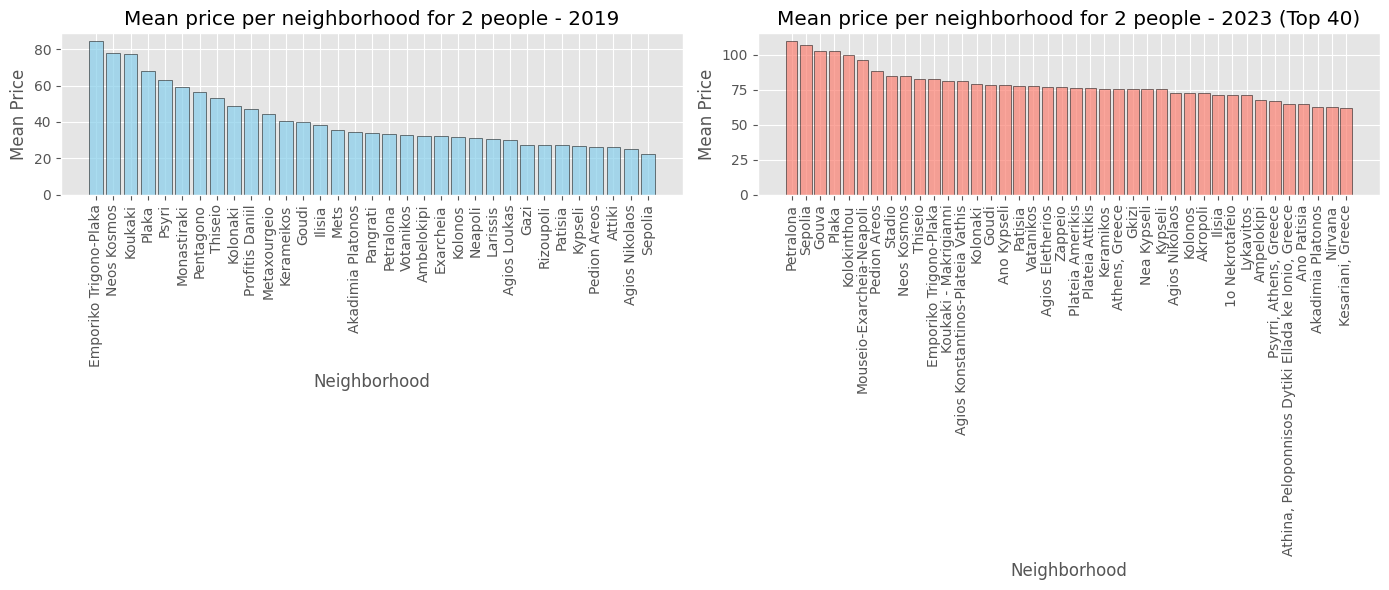

In [61]:
plt.style.use('ggplot')

# keep only the ones that are for 2 peoplee
grouped19 = df2019[df2019['accommodates'] == 2]
grouped23 = df2023[df2023['accommodates'] == 2]

# Group by neighborhood and calculate the mean price
neighborhood_prices19 = grouped19.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)
neighborhood_prices23 = grouped23.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for 2019
axes[0].bar(neighborhood_prices19.index, neighborhood_prices19.values, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Mean price per neighborhood for 2 people - 2019')
axes[0].set_xlabel('Neighborhood')
axes[0].set_ylabel('Mean Price')
axes[0].tick_params(axis='x', rotation=90)

# Plot for 2023 (displaying top 40 neighborhoods)
top_40_neighborhood_prices23 = neighborhood_prices23.head(40)
axes[1].bar(top_40_neighborhood_prices23.index, top_40_neighborhood_prices23.values, color='salmon', edgecolor='black', alpha=0.7)
axes[1].set_title('Mean price per neighborhood for 2 people - 2023 (Top 40)')
axes[1].set_xlabel('Neighborhood')
axes[1].set_ylabel('Mean Price')
axes[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

In [62]:
# Categorize neighborhoods into three groups based on mean price
price_bins19 = pd.qcut(neighborhood_prices19, q=3, labels=['Economical', 'Moderate', 'Expensive'])
neighborhood_prices_grouped19 = neighborhood_prices19.groupby(price_bins19)

print('------------------- 2019 ------------------- ')
for group, neighborhoods in neighborhood_prices_grouped19:
    print(f'{group}: Mean Price = {neighborhoods.mean()}')
    print(neighborhoods)
    print()


price_bins23 = pd.qcut(neighborhood_prices23, q=3, labels=['Economical', 'Moderate', 'Expensive'])
neighborhood_prices_grouped23 = neighborhood_prices23.groupby(price_bins23)

print('------------------- 2023 ------------------- ')
for group, neighborhoods in neighborhood_prices_grouped23:
    print(f'{group}: Mean Price = {neighborhoods.mean()}')
    print(neighborhoods)
    print()

------------------- 2019 ------------------- 
Economical: Mean Price = 27.324498711140645
neighbourhood
Neapoli           30.977273
Larissis          30.849764
Agios Loukas      30.124762
Gazi              27.476923
Rizoupoli         27.377500
Patisia           27.223137
Kypseli           26.959772
Pedion Areos      26.132000
Attiki            26.002254
Agios Nikolaos    24.886102
Sepolia           22.560000
Name: price, dtype: float64

Moderate: Mean Price = 35.02365046594497
neighbourhood
Kerameikos           40.799032
Goudi                39.748571
Ilisia               38.271429
Mets                 35.833939
Akadimia Platonos    34.563077
Pangrati             34.071659
Petralona            33.154915
Votanikos            32.610769
Ambelokipi           32.360052
Exarcheia            32.132902
Kolonos              31.713810
Name: price, dtype: float64

Expensive: Mean Price = 61.82410304196806
neighbourhood
Emporiko Trigono-Plaka    84.600000
Neos Kosmos               77.903801
Koukak

In [63]:
# Get neighborhoods that were Economical in 2019 and still are in 2023
economical_neighborhoods_2019 = neighborhood_prices_grouped19.get_group('Economical')
economical_neighborhoods_2023 = neighborhood_prices_grouped23.get_group('Economical')

# Display neighborhoods that were Economical in 2019 and still are in 2023
economical_neighborhoods_both_years = economical_neighborhoods_2019[economical_neighborhoods_2019.index.isin(economical_neighborhoods_2023.index)]
print('------------------- Economical Neighborhoods in Both Years -------------------')
print(economical_neighborhoods_both_years)
print()

# Get neighborhoods that were Moderate in 2019 and still are in 2023
moderate_neighborhoods_2019 = neighborhood_prices_grouped19.get_group('Moderate')
moderate_neighborhoods_2023 = neighborhood_prices_grouped23.get_group('Moderate')

# Display neighborhoods that were Moderate in 2019 and still are in 2023
moderate_neighborhoods_both_years = moderate_neighborhoods_2019[moderate_neighborhoods_2019.index.isin(moderate_neighborhoods_2023.index)]
print('------------------- Moderate Neighborhoods in Both Years -------------------')
print(moderate_neighborhoods_both_years)
print()

# Get neighborhoods that were Expensive in 2019 and still are in 2023
expensive_neighborhoods_2019 = neighborhood_prices_grouped19.get_group('Expensive')
expensive_neighborhoods_2023 = neighborhood_prices_grouped23.get_group('Expensive')

# Display neighborhoods that were Expensive in 2019 and still are in 2023
expensive_neighborhoods_both_years = expensive_neighborhoods_2019[expensive_neighborhoods_2019.index.isin(expensive_neighborhoods_2023.index)]
print('------------------- Expensive Neighborhoods in Both Years -------------------')
print(expensive_neighborhoods_both_years)
print()

------------------- Economical Neighborhoods in Both Years -------------------
neighbourhood
Gazi         27.476923
Rizoupoli    27.377500
Name: price, dtype: float64

------------------- Moderate Neighborhoods in Both Years -------------------
neighbourhood
Ilisia               38.271429
Akadimia Platonos    34.563077
Pangrati             34.071659
Kolonos              31.713810
Name: price, dtype: float64

------------------- Expensive Neighborhoods in Both Years -------------------
neighbourhood
Emporiko Trigono-Plaka    84.600000
Neos Kosmos               77.903801
Plaka                     67.982464
Thiseio                   53.431579
Kolonaki                  48.623976
Name: price, dtype: float64



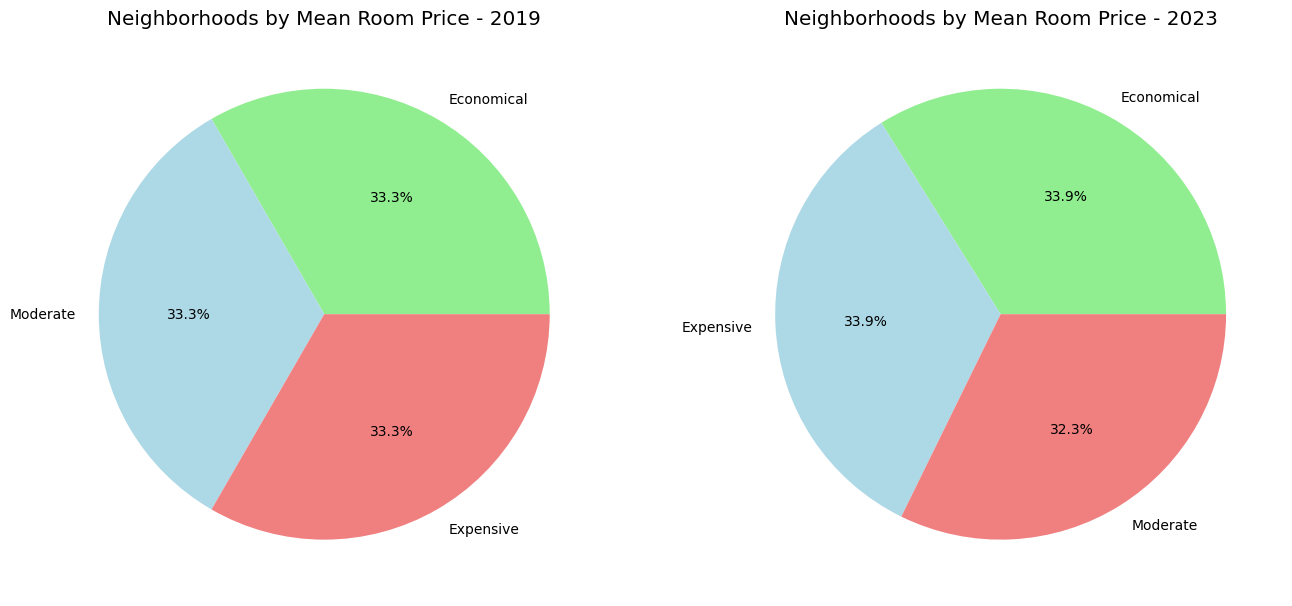

In [64]:
# Categorize neighborhoods into three groups based on mean price
price_bins19 = pd.qcut(neighborhood_prices19, q=3, labels=['Economical', 'Moderate', 'Expensive'])
neighborhood_prices_grouped19 = price_bins19.value_counts()

price_bins23 = pd.qcut(neighborhood_prices23, q=3, labels=['Economical', 'Moderate', 'Expensive'])
neighborhood_prices_grouped23 = price_bins23.value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the categorized neighborhoods for 2019
neighborhood_prices_grouped19.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightblue', 'lightcoral'], ax=axes[0])
axes[0].set_title('Neighborhoods by Mean Room Price - 2019')
axes[0].set_ylabel('')

# Plot the categorized neighborhoods for 2023
neighborhood_prices_grouped23.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightblue', 'lightcoral'], ax=axes[1])
axes[1].set_title('Neighborhoods by Mean Room Price - 2023')
axes[1].set_ylabel('')

plt.show()


## **1.13.1 The best neighborhood in Athens based on their review scores rating**

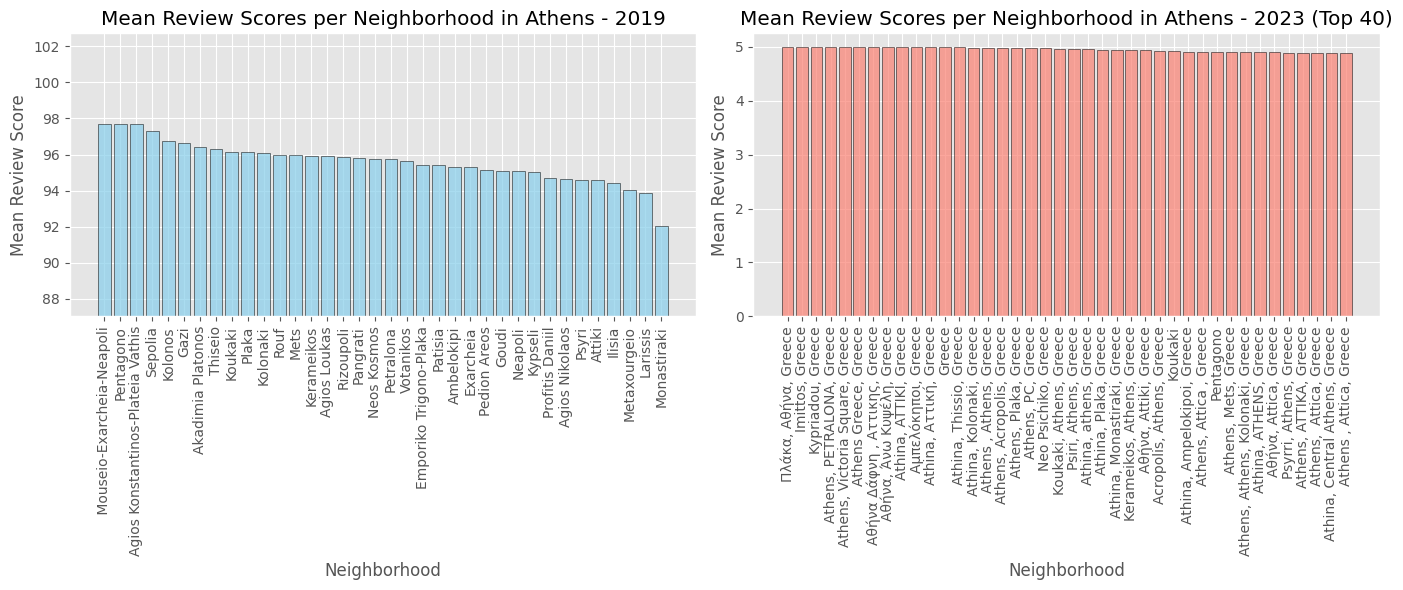

In [65]:
plt.style.use('ggplot')

# keep only the ones that are for 2 peoplee
neighborhood_score19 = df2019.groupby('neighbourhood')['review_scores_rating'].mean().sort_values(ascending=False)
neighborhood_score23 = df2023.groupby('neighbourhood')['review_scores_rating'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for 2019
ax[0].bar(neighborhood_score19.index, neighborhood_score19.values, color='skyblue', edgecolor='black', alpha=0.7)
ax[0].set_title('Mean Review Scores per Neighborhood in Athens - 2019')
ax[0].set_xlabel('Neighborhood')
ax[0].set_ylabel('Mean Review Score')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_ylim(neighborhood_score19.min() - 5, neighborhood_score19.max() + 5)

# Plot for 2023 (displaying top 40 neighborhoods)
top_40_neighborhood_score23 = neighborhood_score23.head(40)
ax[1].bar(top_40_neighborhood_score23.index, top_40_neighborhood_score23.values, color='salmon', edgecolor='black', alpha=0.7)
ax[1].set_title('Mean Review Scores per Neighborhood in Athens - 2023 (Top 40)')
ax[1].set_xlabel('Neighborhood')
ax[1].set_ylabel('Mean Review Score')
ax[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

## **1.13.2 Most expensive property type**

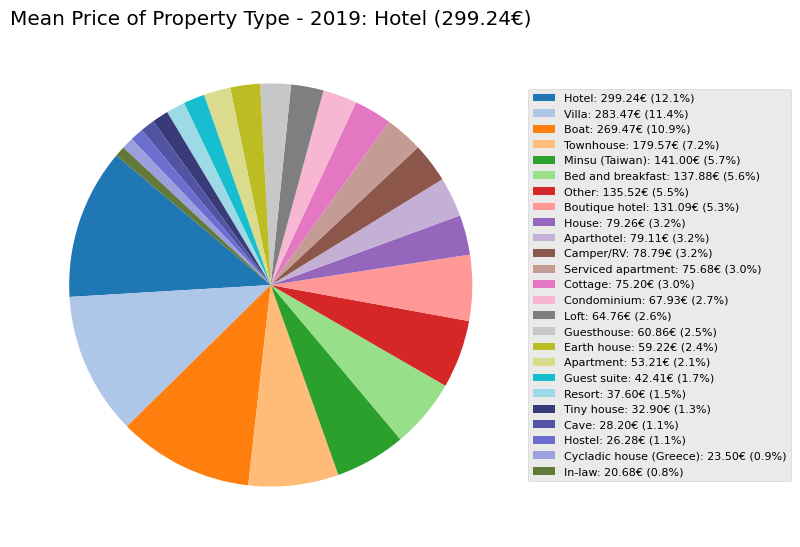

In [66]:
# ------------------------------ 2019 -------------------------------
# Calculate mean prices for property types in 2019
property_type_prices19 = df2019.groupby('property_type')['price'].mean()

# Extracting property types and their mean prices
property_type19 = property_type_prices19.index
mean_prices19 = property_type_prices19.values

# Calculate percentage for each property type
total_price19 = mean_prices19.sum()
percentage19 = 100. * mean_prices19 / total_price19

# Find the most expensive property type
most_expensive_index19 = mean_prices19.argmax()
most_expensive_property_type19 = property_type19[most_expensive_index19]
most_expensive_property_type_price19 = mean_prices19[most_expensive_index19]

# Sort legend based on mean prices
sort_legend = True
if sort_legend:
    sorted_indices = mean_prices19.argsort()[::-1]
    sorted_property_type19 = property_type19[sorted_indices]
    sorted_mean_prices19 = mean_prices19[sorted_indices]
    sorted_percentage19 = percentage19[sorted_indices]

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 8))

# Generate colors from tab20 and tab20b colormaps
colors_tab20 = plt.cm.tab20(range(20))
colors_tab20b = plt.cm.tab20b(range(20))

# Concatenate the two lists of colors
colors = list(colors_tab20) + list(colors_tab20b)

# Create the pie chart with sorted data and colors
patches, texts = ax.pie(sorted_mean_prices19, startangle=140, colors=colors)

ax.set_title(f'Mean Price of Property Type - 2019: {most_expensive_property_type19} ({most_expensive_property_type_price19:.2f}€)')

# Adding legend
plt.legend(patches, labels=[f'{property_type}: {mean_price:.2f}€ ({percent:.1f}%)' for property_type, mean_price, percent in zip(sorted_property_type19, sorted_mean_prices19, sorted_percentage19)], loc='upper left', fontsize=8, bbox_to_anchor=(1, 0.9))

plt.tight_layout()
plt.show()


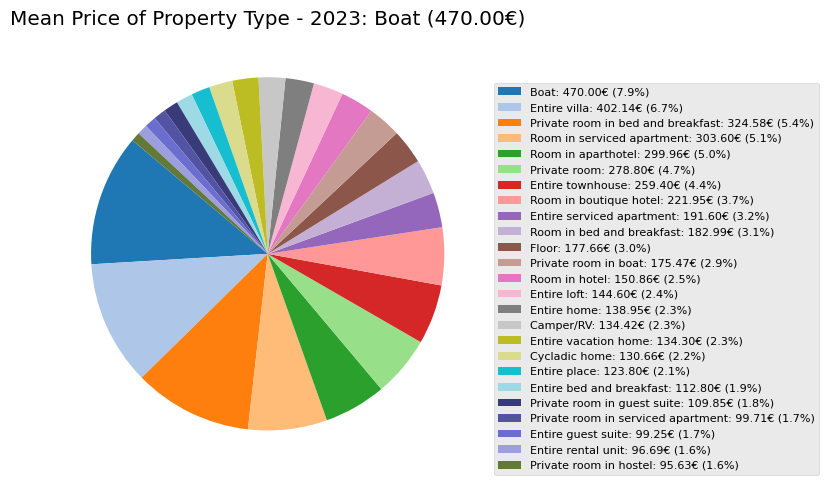

In [67]:
# ------------------------------ 2023 -------------------------------
# Calculate mean prices for property types in 2019
property_type_prices23 = df2023.groupby('property_type')['price'].mean()

# Extracting property types and their mean prices
property_type23 = property_type_prices23.index
mean_prices23 = property_type_prices23.values

# Calculate percentage for each property type
total_price23 = mean_prices23.sum()
percentage23 = 100. * mean_prices23 / total_price23

# Find the most expensive property type
most_expensive_index23 = mean_prices23.argmax()
most_expensive_property_type23 = property_type23[most_expensive_index23]
most_expensive_property_type_price23 = mean_prices23[most_expensive_index23]

# Sort legend based on mean prices
sort_legend = True
if sort_legend:
    sorted_indices = mean_prices23.argsort()[::-1]
    sorted_property_type23 = property_type23[sorted_indices]
    sorted_mean_prices23 = mean_prices23[sorted_indices]
    sorted_percentage23 = percentage23[sorted_indices]

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 8))

# Generate colors from tab20 and tab20b colormaps
colors_tab20 = plt.cm.tab20(range(20))
colors_tab20b = plt.cm.tab20b(range(20))

# Concatenate the two lists of colors
colors = list(colors_tab20) + list(colors_tab20b)

# Create the pie chart with sorted data and colors
patches, texts = ax.pie(sorted_mean_prices19, startangle=140, colors=colors)

ax.set_title(f'Mean Price of Property Type - 2023: {most_expensive_property_type23} ({most_expensive_property_type_price23:.2f}€)')

# Adding legend
plt.legend(patches, labels=[f'{property_type}: {mean_price:.2f}€ ({percent:.1f}%)' for property_type, mean_price, percent in zip(sorted_property_type23, sorted_mean_prices23, sorted_percentage23)], loc='upper left', fontsize=8, bbox_to_anchor=(1, 0.9))

plt.tight_layout()
plt.show()


## **1.13.3 Which neighborhood has the highest availability throughout the year (2019), and what is the most common cancellation policy among listings in that neighborhood?**

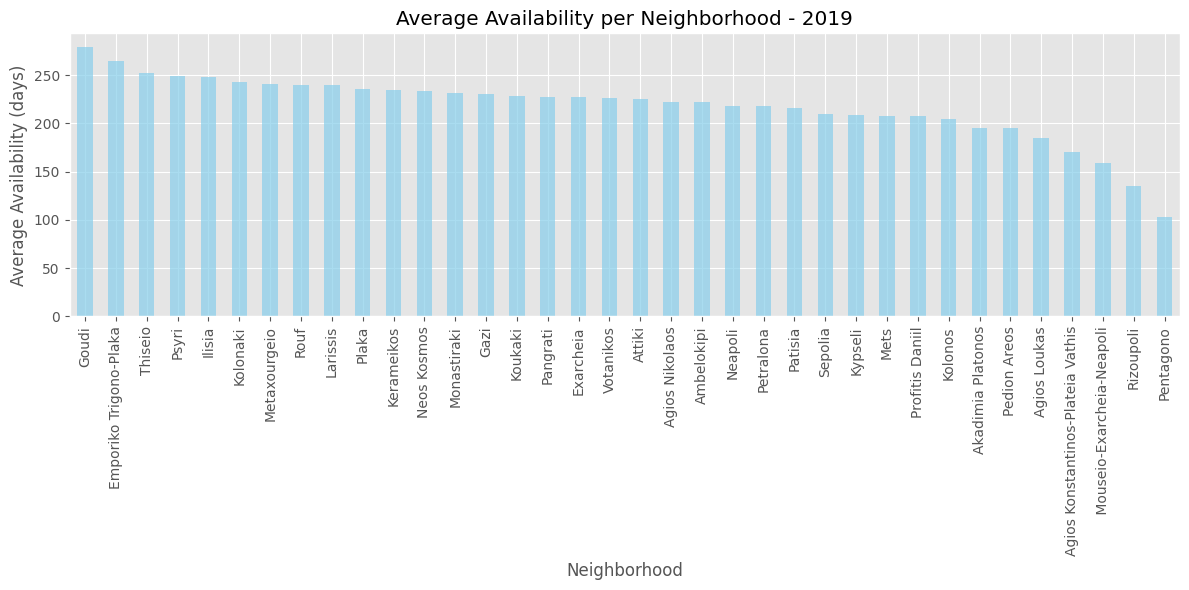

The neighborhood with the highest availability is Goudi with an average availability of 279.47 days per year.
The most common cancellation policy in this neighborhood is flexible.


In [68]:
# Average availability for each neighborhood
neighborhood_availability19 = df2019.groupby('neighbourhood')['availability_365'].mean().sort_values(ascending=False)

# Identify neighborhood with the highest average availability
highest_availability_neighborhood19 = neighborhood_availability19.idxmax()
highest_availability19 = neighborhood_availability19.max()

# The most common cancellation policy in the neighborhood with the highest availability
neighborhood_listings19 = df2019[df2019['neighbourhood'] == highest_availability_neighborhood19]
common_cancellation_policy19 = neighborhood_listings19['cancellation_policy'].mode()[0]

plt.figure(figsize=(12, 6))
neighborhood_availability19.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Average Availability per Neighborhood - 2019')
plt.xlabel('Neighborhood')
plt.ylabel('Average Availability (days)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print(f"The neighborhood with the highest availability is {highest_availability_neighborhood19} with an average availability of {highest_availability19:.2f} days per year.")
print(f"The most common cancellation policy in this neighborhood is {common_cancellation_policy19}.")

## **1.14 Hosts with the most entries**

In [69]:
host_listings_count19 = df2019.groupby(['host_id', 'host_name']).size().reset_index(name='num_host_listings2019')
top_10_hosts19 = host_listings_count19.sort_values(by='num_host_listings2019', ascending=False).head(10)

host_listings_count23 = df2023.groupby(['host_id', 'host_name']).size().reset_index(name='num_host_listings2023')
top_10_hosts23 = host_listings_count23.sort_values(by='num_host_listings2023', ascending=False).head(10)

print('------------------- 2019 ------------------- ')
print(top_10_hosts19)
print()

print('------------------- 2023 ------------------- ')
print(top_10_hosts23)
print()

common_hosts = pd.merge(top_10_hosts19, top_10_hosts23, on=['host_id', 'host_name'], how='inner')

# Print the common hosts
print('Common Hosts between 2019 and 2023:')
print(common_hosts)

------------------- 2019 ------------------- 
        host_id                      host_name  num_host_listings2019
2405   77457889                     Παναγιώτης                    378
1216   29927830  Dimitris, Konstantinos & Sevi                    263
3390  135482892                           Home                    245
73       748818                         George                    228
135     1621474                   Eazybnb Team                    204
120     1418201                           Dean                    189
2977  112527018                           Toni                    171
157     2089542                     Tia & Mike                    135
2134   65714690                           Home                    126
1903   55670751                             Jj                    126

------------------- 2023 ------------------- 
        host_id    host_name  num_host_listings2023
613    20104194     Upstreet                    330
1809   90390850  Evan&Anetta     

## **1.15 Observations**

Βασιζόμενοι στα γραφήματα και τα δεδομένα που παρουσιάστηκαν παραπάνω, μπορούμε να συμπεράνουμε τα ακόλουθα:

**1. Γειτονιές:**
      Ενώ το 2019 υπάρχει μια ποικιλία από γειτονιές, όπως Πλάκα, Κουκάκι, Νέος κόσμος, Παγκράτι, τις οποίες επιλέγει ένας επισκέπτης για να μείνει, το 2023 η πλειονότητα των επισκεπτών συσσωρεύεται στην Αθήνα.  
      (Ερωτήματα 1.3, 1.4, 1.5)

**2.   Τιμές:**
      Όπως φαίνεται στο δεύτερο ερώτημα, οι τιμές των Airbnb για το τρίμηνο του 2019, είχαν καθοδική πορεία ενώ για το 2023 ανοδική. Το γεγονός αυτό αποτυπώνεται και στα γραφήματα των ερωτημάτων 1.8, 1.12, 1.13.2, όπου οι τιμές συγκριτικά με το 2019 είναι αυξημένες, καθώς υπάρχει αύξηση του κόστους ζωής. Ειδικότερα, από το ερώτημα 1.12, μπορούμε να συμπεράνουμε ότι οι μεταβολές στην οικονομία οδήγησαν σε αντίστοιχες μεταβολές στα ακίνητα καθώς λίγες είναι οι γειτονιές που διατήρησαν σταθερές τιμές (ίδια κατηγορία) και τις δύο χρονιές.

**3.  Τύπος διαμονής:**
      Ανεξάρτητα από την αύξηση των τιμών, οι τουρίστες συνεχίζουν να επιλέγουν ολόκληρο σπίτι ή διαμέρισμα για την διαμονή τους, δεδομένου ότι παρέχει περισσότερη ελευθερία και προνόμια από άλλες επιλογές.
      (Ερωτήματα 1.1, 1.7, 1.8)

Συνολικά, η σύγκριση μεταξύ των δύο ετών αποκαλύπτει μια δυναμική αγοράς βραχυπρόθεσμων μισθώσεων στην Αθήνα, με αυξημένη ποικιλία επιλογών για τους επισκέπτες και μια γενική τάση αύξησης των τιμών.








## **2. Recommendation System**

In [70]:
# We only need columns  'id', 'name', 'description'.
df2019 = df2019[['id', 'name', 'description']]
df2019.fillna('NULL',inplace=True) # replacing NAN with NULL string
df2019.info()

df2023 = df2023[['id', 'name', 'description']]
df2023.fillna('NULL',inplace=True) # replacing NAN with NULL string
df2023.info()

#Process the text - Stop words
def preprocess_text(text):
    text = re.sub(r'[^\w\d\s]', ' ', text)                  # remove all punctuation
    ext = re.sub(r'[^\w\d\s]|[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]', ' ', text) # remove emojis
    text = re.sub(r'\s+', ' ', text)                        # remove all whitespaces
    text = re.sub(r'^\s+|\s+?$', '', text.lower())          # from upper case to lower case
    stop_words = nltk.corpus.stopwords.words('english')     # remove stop words
    lemmatizer = WordNetLemmatizer()
    return ' '.join(
        lemmatizer.lemmatize(term)
        for term in text.split()
        if term not in set(stop_words)
    )

# Concatenate name and description in one column and perform preprocessing
df2019['info'] = df2019['name'] + " " + df2019['description']
df2019['processed_info'] = df2019['info'].apply(lambda row : preprocess_text(row))
df2019.drop_duplicates(subset=['id'], keep='first', inplace=True)
df2019.head()


<class 'pandas.core.frame.DataFrame'>
Index: 28905 entries, 0 to 9582
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28905 non-null  int64 
 1   name         28905 non-null  object
 2   description  28905 non-null  object
dtypes: int64(1), object(2)
memory usage: 903.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 37018 entries, 0 to 12327
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           37018 non-null  int64 
 1   name         37018 non-null  object
 2   description  37018 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


id                                 name  \
0  10595  96m2, 3BR, 2BA, Metro, WI-FI etc...   
1  10988   75m2, 2-br, metro, wi-fi, cable TV   
2  10990    50m2, Metro, WI-FI, cableTV, more   
3  10993  Studio, metro, cable tv, wi-fi, etc   
4  10995  47m2, close to metro,cable TV,wi-fi   

                                         description  \
0  Athens Furnished Apartment No6 is 3-bedroom ap...   
1  Athens Furnished Apartment No4 is 2-bedroom ap...   
2  Athens Furnished Apartment No3 is 1-bedroom ap...   
3  The Studio is an  -excellent located  -close t...   
4  AQA No2 is 1-bedroom apartment (47m2)  -excell...   

                                                info  \
0  96m2, 3BR, 2BA, Metro, WI-FI etc... Athens Fur...   
1  75m2, 2-br, metro, wi-fi, cable TV Athens Furn...   
2  50m2, Metro, WI-FI, cableTV, more Athens Furni...   
3  Studio, metro, cable tv, wi-fi, etc The Studio...   
4  47m2, close to metro,cable TV,wi-fi AQA No2 is...   

                                      processed_info  
0  96m2 3br 2ba metro wi fi etc athens furnished ...  
1  75m2 2 br metro wi fi cable tv athens furnishe...  
2  50m2 metro wi fi cabletv athens furnished apar...  
3  studio metro cable tv wi fi etc studio excelle...  
4  47m2 close metro cable tv wi fi aqa no2 1 bedr...

In [71]:
df2023['info'] = df2023['name'] + " " + df2023['description']
df2023['processed_info'] = df2023['info'].apply(lambda row : preprocess_text(row))
df2023.drop_duplicates(subset=['id'], keep='first', inplace=True)
df2023.head()

id                                               name  \
0   10595  Condo in Athens · ★4.83 · 3 bedrooms · 5 beds ...   
1   10990  Rental unit in Athens · ★4.80 · 1 bedroom · 1 ...   
2   10993  Rental unit in Athens · ★4.84 · Studio · 2 bed...   
3   10995  Rental unit in Athens · ★4.80 · 1 bedroom · 2 ...   
4  695173  Condo in Athens · ★4.88 · 2 bedrooms · 3 beds ...   

                                         description  \
0  The apartment is 3-bedroom apartment with 2-ba...   
1  Athens Quality Apartments - Deluxe apartment i...   
2  The Studio is an <br />-excellent located <br ...   
3  AQA No2 is 1-bedroom apartment (47m2), on the ...   
4  My unique artistic comfortable two bedroom apa...   

                                                info  \
0  Condo in Athens · ★4.83 · 3 bedrooms · 5 beds ...   
1  Rental unit in Athens · ★4.80 · 1 bedroom · 1 ...   
2  Rental unit in Athens · ★4.84 · Studio · 2 bed...   
3  Rental unit in Athens · ★4.80 · 1 bedroom · 2 ...   
4  Condo in Athens · ★4.88 · 2 bedrooms · 3 beds ...   

                                      processed_info  
0  condo athens 4 83 3 bedroom 5 bed 2 bath apart...  
1  rental unit athens 4 80 1 bedroom 1 bed 1 bath...  
2  rental unit athens 4 84 studio 2 bed 1 bath st...  
3  rental unit athens 4 80 1 bedroom 2 bed 1 bath...  
4  condo athens 4 88 2 bedroom 3 bed 2 bath uniqu...

## **2.1 Create Term Frequency - Inverse Document Frequency**

In [72]:
# Create TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

# Create  TF-IDF matrix
tfidf_matrix19 = tfidf_vectorizer.fit_transform(df2019['processed_info'])
print(tfidf_matrix19.shape)

# Same for 2023
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
tfidf_matrix23 = tfidf_vectorizer.fit_transform(df2023['processed_info'])
print(tfidf_matrix23.shape)


(9661, 249209)
(17149, 239163)


## **2.2 Cosine Similarity**

In [73]:
#----------------------- 2019 -----------------------
# high similarity means a cosine close to 1
# low similarity means a cosine close to 0

cosine_similarity19 = cosine_similarity(tfidf_matrix19)
cosine_similarity23 = cosine_similarity(tfidf_matrix23)
# print(cosine_similarity19)  1 stin diagonio

# Εχουμε εναν πίνακα με όλες τις ομοιότητες και
# ψάχνουμε για κάθε ακίνητο με ποιό είναι πιο όμοιο
# Άρα, από κάθε γραμμή το μέγιστο.

similar_properties19 = {}
xindex = 0
id_list = df2019['id'].tolist()
for x in cosine_similarity19:
    max = x[0]                                      # to store the max element each time
    maxindex = 0                                    # the index of the max element so i can access it every time
    index = xindex+1                                # check if from x idex utill the end there is a max element
    for index in range(xindex+1,len(x)):
        if x[index]>max:
            max=x[index]
            maxindex=index
        index+=1
    idtuple = (id_list[xindex],id_list[maxindex])   #store the id of the two properties
    similar_properties19[idtuple] = max
    xindex+=1

# sort
sorted_dict = {k: similar_properties19[k] for k in sorted(similar_properties19, key=similar_properties19.get, reverse=True)}
top_100 = dict(itertools.islice(sorted_dict.items(), 100))

print('100 most similar accommodations in Athens - 2019\n')

for i, (ids, similarity) in enumerate(top_100.items(), start=1):
    print(f"{i}. Accommodation pair: {ids}, Similarity: {similarity}")

100 most similar accommodations in Athens - 2019

1. Accommodation pair: (20686418, 20692552), Similarity: 1.0000000000000004
2. Accommodation pair: (20692552, 20704187), Similarity: 1.0000000000000004
3. Accommodation pair: (20704187, 20705564), Similarity: 1.0000000000000004
4. Accommodation pair: (20705564, 20706206), Similarity: 1.0000000000000004
5. Accommodation pair: (20706206, 20707116), Similarity: 1.0000000000000004
6. Accommodation pair: (26383438, 26620126), Similarity: 1.0000000000000004
7. Accommodation pair: (29718779, 33355636), Similarity: 1.0000000000000004
8. Accommodation pair: (30268642, 30286826), Similarity: 1.0000000000000004
9. Accommodation pair: (32508932, 32733961), Similarity: 1.0000000000000004
10. Accommodation pair: (32801843, 32803315), Similarity: 1.0000000000000004
11. Accommodation pair: (32803315, 32804356), Similarity: 1.0000000000000004
12. Accommodation pair: (32804356, 32804884), Similarity: 1.0000000000000004
13. Accommodation pair: (33396807, 

In [74]:
similar_properties23 = {}
xindex = 0
id_list = df2023['id'].tolist()
for x in cosine_similarity23:
    max = x[0]                                      # to store the max element each time
    maxindex = 0                                    # the index of the max element so i can access it every time
    index = xindex+1                                # check if from x idex utill the end there is a max element
    for index in range(xindex+1,len(x)):
        if x[index]>max:
            max=x[index]
            maxindex=index
        index+=1
    idtuple = (id_list[xindex],id_list[maxindex])   #store the id of the two properties
    similar_properties23[idtuple] = max
    xindex+=1

# sort
sorted_dict = {k: similar_properties23[k] for k in sorted(similar_properties23, key=similar_properties23.get, reverse=True)}
top_100 = dict(itertools.islice(sorted_dict.items(), 100))

print('100 most similar accommodations in Athens - 2023\n')

for i, (ids, similarity) in enumerate(top_100.items(), start=1):
    print(f"{i}. Accommodation pair: {ids}, Similarity: {similarity}")

100 most similar accommodations in Athens - 2023

1. Accommodation pair: (906880762554511072, 906880762554511104), Similarity: 1.0000000000000022
2. Accommodation pair: (784699969844235477, 784699969844235520), Similarity: 1.000000000000002
3. Accommodation pair: (875037443520762129, 875037443520762112), Similarity: 1.000000000000002
4. Accommodation pair: (781523620785882567, 781523620785882624), Similarity: 1.0000000000000018
5. Accommodation pair: (595591202071580084, 595591202071580032), Similarity: 1.0000000000000016
6. Accommodation pair: (833948299783926824, 833948299783926784), Similarity: 1.0000000000000016
7. Accommodation pair: (845647990960733085, 845647990960733056), Similarity: 1.0000000000000016
8. Accommodation pair: (855553501127710354, 855553501127710336), Similarity: 1.0000000000000016
9. Accommodation pair: (910021031404708150, 910021031404708096), Similarity: 1.0000000000000016
10. Accommodation pair: (684731740178019809, 684731740178019840), Similarity: 1.00000000

## **2.3 recommend function**

In [75]:
# high similarity means disance close to 0
# low similarity means disance close to 1

import textwrap

def recommend(item_id=10988, num=20):
    id_list = df2019.index[df2019['id'] == item_id].tolist()  # keep only for a specific id
    if len(id_list) > 0:
        listing_id = id_list[0]
        item_name = df2019.loc[df2019['id'] == item_id, 'name'].iloc[0]
    else:
        print('No such listing found')
        return

    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(tfidf_matrix19)

    distances, indices = model_knn.kneighbors(tfidf_matrix19[listing_id].reshape(1, -1), n_neighbors=num)

    print('Recommending {} listings similar to:'.format(num))
    print("{}\n".format(df2019.iloc[df2019.index[indices.flatten()[0]]]['name']))

    # Wrap description to fit in multiple lines
    description = textwrap.fill(df2019.iloc[df2019.index[indices.flatten()[0]]]['description'], width=80)
    print('Description: \n"{}"\n'.format(description))

    for i in range(1, len(distances.flatten())):
        print('------------------------------------------------------------------------------------------------------------------')
        print("Recommended {}: {}\n".format(i, df2019.iloc[df2019.index[indices.flatten()[i]]]['name']))

        # Wrap description to fit in multiple lines
        description = textwrap.fill(df2019.iloc[df2019.index[indices.flatten()[i]]]['description'], width=80)
        print('Description: \n"{}"\n'.format(description))

        print('(score: {})'.format(distances.flatten()[i]))

recommend()


Recommending 20 listings similar to:
75m2, 2-br, metro, wi-fi, cable TV

Description: 
"Athens Furnished Apartment No4 is 2-bedroom apartment (75 square meters)
-excellent located  -close to metro station,  -lovely,  -very clean  with all
the facilities that you will need, nice balcony, excellent Wi-Fi, cable tv,
fully air conditioned… Athens Furnished Apartment No4 is an excellent located,
close to metro, lovely, very clean 2-bedroom apartment (75 square meters) with
all the facilities that you will need and nice balcony. Fully equipped kitchen
with everything you need to prepare your lunch/dinner. Living room to relax and
enjoy a movie or a sport event. Big dinner table. Clean nice bathroom. For more
than 4 people there is a camp bed. Apartment No4 has everything you will need.
-Telephone line for incoming calls or to call us if you need something. -Free
fast Wi-Fi from the best internet provider in Greece. You do not share the
connection with other people. -32” tv  & DVD player -Cab

## **2.4 Most common used words**

In [76]:
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(' '.join(list(df2019['description'])).split())
top10_collocations19 = finder.nbest(BigramAssocMeasures.pmi, 10)
print("Top 10 Collocations 2019: \n")
for pair_words in top10_collocations19:
    print("{} - {}".format(pair_words[0], pair_words[1]))

Top 10 Collocations 2019: 

"1920's - Residence"
"33 - Strofes
"9th - Heaven"
"AGHIOS - NIKOLAOS"which
"Agia - Marina"
"Agias - Eirinis"
"Akadimia - Platonos"
"Areos - park"
"Attica - Grove's
"Blue - Building",


In [77]:
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(' '.join(list(df2023['description'])).split())
top10_collocations23 = finder.nbest(BigramAssocMeasures.pmi, 10)
print("Top 10 Collocations 2023: \n")
for pair_words in top10_collocations23:
    print("{} - {}".format(pair_words[0], pair_words[1]))

Top 10 Collocations 2023: 

"5 - STARS"
"9th - Heaven"
"Acadimia - Platonos"
"Agia - Marina"
"Akadimia - Platonos"<br
"Angel - Pardalos".
"Apostolou - Pavlou"
"Attica - Grove's
"Cine - Thision",
"Curriculum - Vitae


In [78]:
common_collocations = set(top10_collocations19).intersection(top10_collocations23)

# Εκτυπώστε τις κοινές λέξεις
print("Common Collocations in 2019 and 2023:")
for collocation in common_collocations:
    print(collocation)

Common Collocations in 2019 and 2023:
('"Agia', 'Marina"')
('"Attica', "Grove's")
('"9th', 'Heaven"')
